Vítejte u domácí úlohy do SUI.
V rámci úlohy Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu, místo na ně je vyznačené jako `pass` nebo `None`.
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
V dvou případech se očekává textová odpověď, tu uvedete přímo do zadávající buňky.
Buňky nerušte ani nepřidávejte.

Maximálně využívejte `numpy` a `torch` pro hromadné operace na celých polích.
S výjimkou generátoru minibatchí by se nikde neměl objevit cyklus jdoucí přes jednotlivé příklady.

U všech cvičení je uveden počet bodů za funkční implementaci a orientační počet potřebných řádků.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte pouze, pokud ho významně překračujete.
Mnoho zdaru!

# Informace o vzniku řešení
Vyplňte následující údaje **(3 údaje, 0 bodů)**

* Jméno autora: Katerina Fortova
* Login autora: xforto00
* Datum vzniku: 21. 10. 2020

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats
import torch

# Přípravné práce
Prvním úkolem v této domácí úloze je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:
- pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7])
- všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N])

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřování a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives,negatives}.trn`), validační (`{positives,negatives}.val`) a testovací (`{positives,negatives}.tst`) dataset, pojmenujte je po řadě (`train_dataset`, `val_dataset`, `test_dataset`). 

**(6+3 řádků, 1 bod)** 


In [4]:
class dataset:
    def __init__(self, dataset):
        self.pos = np.loadtxt("positives." + dataset)
        self.neg = np.loadtxt("negatives." + dataset)
        
        self.xs = np.concatenate((self.pos, self.neg))
        self.xs_rows = np.shape(self.xs)[0]
        #print(self.xs_rows)
        
        self.pos_target = np.full((np.shape(self.pos)[0],),1)
        self.neg_target = np.full((np.shape(self.neg)[0],),0)
        self.targets = np.concatenate((self.pos_target, self.neg_target))
        #print(self.targets)
        
        #self.targets = self.targets.ravel()
        
train_dataset = dataset("trn")
val_dataset = dataset("val")
test_dataset = dataset("tst")

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)


positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte pro začátek funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů (`plt.hist()`). Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavolejte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data **(5 řádků, 1 bod)**.

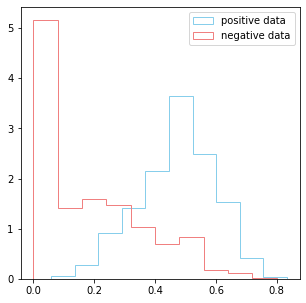

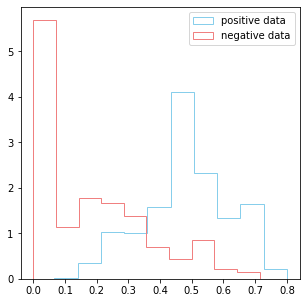

In [5]:
FOI = 5  # Feature Of Interest

def plot_data(poss, negs):
    figure = plt.figure(figsize=(5, 5))
    graph_plot = figure.add_subplot(1,1,1)
    graph_plot.hist(poss, density=True, histtype='step', color = "skyblue", label="positive data")
    graph_plot.hist(negs, density=True, histtype='step', color = "lightcoral", label="negative data")
    graph_plot.legend(prop={'size': 10})
    


plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

### Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N] nebo [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_, tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 (tj. p(y=1|x)) pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat mezi sebou i se skalárem.

**(3 řádky, 1 bod)**

In [6]:
def evaluate(classifier, inputs, targets):
    classifier = Dummy()
    dummy_result = classifier.prob_class_1(inputs)
    k = np.where(dummy_result<0.5,0,np.where(dummy_result>=0.5,1,dummy_result))
    matches = np.where(k==targets)
    accuracy = np.shape(matches)[1] / np.shape(targets)[0]
    return accuracy


class Dummy:
    def prob_class_1(self, xs):
        return np.asarray([0.2, 0.7, 0.7])

print(evaluate(Dummy(), None, np.asarray([0, 0, 1])))  # should be 0.66...

0.6666666666666666


### Baseline
Vytvořte klasifikátor, který ignoruje vstupní hodnotu dat.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti, využijte `np.ones` nebo `np.full`.

**(4 řádky, 1 bod)**

In [7]:
def evaluate(classifier, inputs, targets):
    prior_result = classifier.prob_class_1(inputs)
    return prior_result

class PriorClassifier:
    def __init__(self, class_type):
        self.class_type = class_type
    def prob_class_1(self, xs):
        self.predictions_arr = np.full((np.shape(xs)[0],),self.class_type)
        return self.predictions_arr
    

baseline = PriorClassifier(0)
val_acc = evaluate(baseline, val_dataset.xs[:, FOI], val_dataset.targets)
print('Baseline val acc:', val_acc)

Baseline val acc: [0 0 0 ... 0 0 0]


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypište.

**(5 řádků, 0.5 bodu)**

In [8]:
def maximumLikelihood(inputs):
    results = list()
    mu, std = scipy.stats.norm.fit(inputs)
    print("Mean: " + str(mu))
    print("Standard Deviation: " + str(std))
    results.append(mu)
    results.append(std)
    return results

pos_features_pdf = maximumLikelihood(train_dataset.pos[:, FOI])
neg_features_pdf = maximumLikelihood(train_dataset.neg[:, FOI])


Mean: 0.478428821613158
Standard Deviation: 0.12971703647258465
Mean: 0.17453641132613792
Standard Deviation: 0.17895975196381242


Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2+8 řádků, 1 bod)**

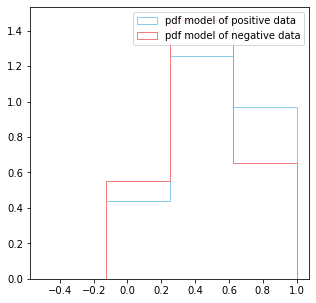

In [9]:
def plotPdf(poss, negs, poss_features, negs_features):
    p_poss = scipy.stats.norm.pdf(poss, poss_features[0], poss_features[1])
    p_negs = scipy.stats.norm.pdf(negs, negs_features[0], negs_features[1])
    
    figure = plt.figure(figsize=(5, 5))
    graph_plot = figure.add_subplot(1,1,1)
    graph_plot.hist(p_poss,bins=np.linspace(-0.5,1,5), histtype='step',  density=True, color = "skyblue", label="pdf model of positive data")
    graph_plot.hist(p_negs,bins=np.linspace(-0.5,1,5), histtype='step', density=True, color = "lightcoral", label="pdf model of negative data")
    graph_plot.legend(prop={'size': 10})
    #graph_plot.set_xlim([-0.5,1.5])

plotPdf(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI], pos_features_pdf, neg_features_pdf)

Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Jako všechny klasifikátory v této domácí úloze poskytuje metodu `prob_class_1()`.

**(9 řádků, 2 body)**

In [10]:
def evaluate(classifier, poss_features, negs_features, val_dataset, targets):
    results = classifier.prob_class_1(poss_features, negs_features, val_dataset, targets)
    return results
    

class BinaryClassifier:
    def __init__(self, class_type):
        self.class_type = class_type
        
    def prob_class_1(self, poss_features, negs_features, val_dataset, targets):
        predicted_classes = list()
        results = list()
        for x in val_dataset:
            #x_float = float(x)
            if (self.class_type == "normal"):
                poss_probability = scipy.stats.norm(poss_features[0], poss_features[1]).pdf(x) * 0.5
                negs_probability = scipy.stats.norm(negs_features[0], negs_features[1]).pdf(x) * 0.5
                
            elif (self.class_type == "aprior"):
                poss_probability = scipy.stats.norm(poss_features[0], poss_features[1]).pdf(x) * 0.25
                negs_probability = scipy.stats.norm(negs_features[0], negs_features[1]).pdf(x) * 0.75

            if (poss_probability > negs_probability):
                predicted_class = 1
            else:
                predicted_class = 0
                
            predicted_classes.append(predicted_class)
        
        #print(predicted_classes)
        matches = np.where(predicted_class==targets)
        #print(matches)
        #print(np.shape(matches))
        accuracy = (np.shape(matches)[1] / np.shape(targets)[0]) 
        accuracy_percent = accuracy * 100
        #print("Accuracy: " + str(accuracy_percent) + " %")
        results.append(predicted_classes)
        results.append(accuracy)
            
        return results

classifier = BinaryClassifier("normal")
accuracy = evaluate(classifier, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[1]
print(accuracy)

0.75


Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnoťte jejich úspěšnost na validačních datech.

**(2 řádky, 1 bod)**

In [11]:
classifier_flat_prior = None
classifier_full_prior = None

classifier_flat_prior = BinaryClassifier("normal")
classifier_full_prior = BinaryClassifier("aprior")

print('flat:', evaluate(classifier_flat_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[1])
print('full:', evaluate(classifier_full_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[1])

flat_prior_predictions = evaluate(classifier_flat_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[0]
full_prior_predictions = evaluate(classifier_full_prior, pos_features_pdf, neg_features_pdf, val_dataset.xs[:, FOI], val_dataset.targets)[0]

flat: 0.75
full: 0.75


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5 pro oba klasifikátory, opět v rozsahu <-0.5; 1.5>.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků, 1 bod)**

Text(0.5, 1.0, 'Histogram for Full Prior Classifier')

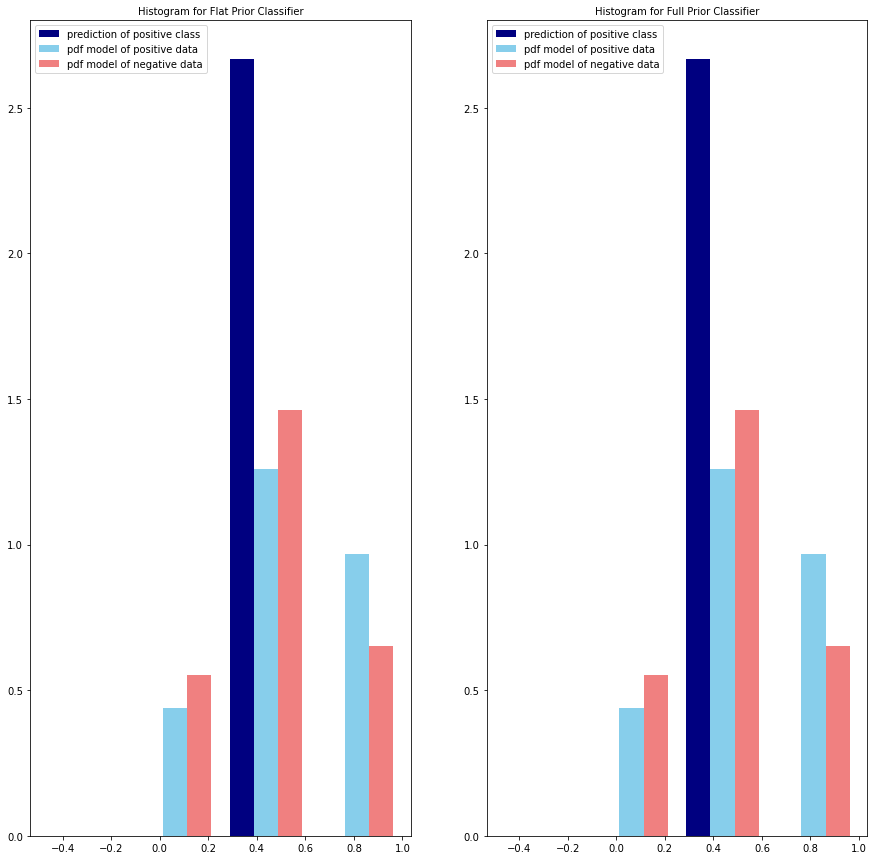

In [12]:
def getPointsToPlot(all_points, all_predictions):
    points_to_plot = list()
    all_points = all_points.tolist()
    for point in all_points:
        for prediction in all_predictions:
            if (all_points.index(point) == all_predictions.index(prediction)):
                if (prediction == 1):
                    points_to_plot.append(point)
    return points_to_plot

p_poss = scipy.stats.norm.pdf(train_dataset.pos[:, FOI], pos_features_pdf[0], pos_features_pdf[1])
p_negs = scipy.stats.norm.pdf(train_dataset.neg[:, FOI], neg_features_pdf[0], neg_features_pdf[1])

points_to_plot_flat = getPointsToPlot(val_dataset.xs[:, FOI], flat_prior_predictions)
points_to_plot_full = getPointsToPlot(val_dataset.xs[:, FOI], full_prior_predictions)
            
figure = plt.figure(figsize=(15, 15))

graph_plot_flat = figure.add_subplot(1,2,1)
graph_plot_flat.hist([points_to_plot_flat, p_poss, p_negs] ,bins=np.linspace(-0.5,1,5), density=True, color =["navy","skyblue","lightcoral"] , label=["prediction of positive class", "pdf model of positive data", "pdf model of negative data"])
graph_plot_flat.legend(prop={'size': 10})
graph_plot_flat.set_title("Histogram for Flat Prior Classifier", fontsize=10)

graph_plot_full = figure.add_subplot(1,2,2)
graph_plot_full.hist([points_to_plot_full, p_poss, p_negs] ,bins=np.linspace(-0.5,1,5), density=True, color =["navy","skyblue","lightcoral"] , label=["prediction of positive class", "pdf model of positive data", "pdf model of negative data"])
graph_plot_full.legend(prop={'size': 10})
graph_plot_full.set_title("Histogram for Full Prior Classifier", fontsize=10)





Interpretujte, přímo v této textové buňce, každou rozhodovací hranici, která je v grafu patrná **(3 věty, 2 body)**:

# Diskriminativní klasifikátory
V následující části budete přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny na PyTorchi, ten si prosím nainstalujte.
GPU rozhodně nepotřebujete, veškeré výpočty budou velmi rychlé, ne-li bleskové.

Do začátku máte poskytnutou třídu klasifikátoru z jednoho příznaku.

In [13]:
import torch
import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.parameter.Parameter(torch.tensor([1.0]))
        self.b = torch.nn.parameter.Parameter(torch.tensor([0.0]))
        
    def forward(self, x):
        return torch.sigmoid(self.w*x + self.b)
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Pro trénovaní diskriminativních modelů budete potřebovat minibatche.
Implementujte funkci, která je bude z daných vstupních a cílových hodnot vytvářet.
Výsledkem musí být možno iterovat, ideálně funkci napište jako generátor (využijte klíčové slovo `yield`).
Jednotlivé prvky výstupu budou dvojice PyTorchových `FloatTensor`ů (musíte zkonvertovat z numpy a nastavit typ) -- první prvek vstupní data, druhý očekávané výstupy.
Počítejte s tím, že vstup bude `numpy`ovské pole, rozumná implementace využije `np.random.permutation()` a [Advanced Indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Připravený kód funkci použije na konstrukci tří minibatchí pro trénování identity, měli byste vidět celkem pět prvků náhodně uspořádaných do dvojic, ovšem s tím, že s sebou budou mít odpovídající výstupy.

**(6 řádků, 2 body)**

In [50]:
def batch_provider(xs, targets, batch_size=10):
    data_torch = torch.from_numpy(xs).float()
    targets_torch = torch.from_numpy(targets).float()
    print(data_torch)
    print(targets_torch)
    
    dataset = torch.utils.data.TensorDataset(data_torch, targets_torch)
    print(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return dataloader

inputs = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
targets = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
for x, t in batch_provider(inputs, targets, 2):
    print(f'x: {x}, t: {t}')

tensor([1., 2., 3., 4., 5.])
tensor([1., 2., 3., 4., 5.])
x: tensor([5., 4.]), t: tensor([5., 4.])
x: tensor([3., 1.]), t: tensor([3., 1.])
x: tensor([2.]), t: tensor([2.])


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii (`F.binary_cross_entropy()`), akumulujte ji přes minibatche a logujte průměr.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

V implementaci budete potřebovat dvě zanořené smyčky: jednu pro epochy (průchody přes celý dataset) a uvnitř druhou, která bude iterovat přes jednotlivé minibatche.
Na konci každé epochy vyhodnoťte model na validačních datech.
K datasetům (trénovacímu a validačnímu) přistupujte bezostyšně jako ke globálním proměnným.

**(cca 14 řádků, 3 body)**

In [54]:
def train_single_fea_llr(fea_no, nb_epochs, lr, batch_size):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    inputs = train_dataset.xs[:, FOI]
    targets = train_dataset.targets
    dataloader = batch_provider(inputs, targets, 2)
    
       
    #pass
    for i in range(nb_epochs):
        for x, t in batch_provider(inputs, targets, batch_size):
            print(f'x: {x}, t: {t}')
            print(x[0])
            
            
        
        
    return best_model, losses, accuracies


inputs = train_dataset.xs[:, FOI]
print(inputs.shape)
targets = train_dataset.targets
print(targets.shape)

train_single_fea_llr(5, 20, 1, 2)


(9121,)
(9121,)
tensor([0.6250, 0.3333, 0.4737,  ..., 0.5000, 0.0000, 0.0833])
tensor([1., 1., 1.,  ..., 0., 0., 0.])
tensor([0.6250, 0.3333, 0.4737,  ..., 0.5000, 0.0000, 0.0833])
tensor([1., 1., 1.,  ..., 0., 0., 0.])
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.4286]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1200]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1538, 0.6250]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.1579, 0.0000]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([

tensor(0.2414)
x: tensor([0.6000, 0.4000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3600, 0.0833]), t: tensor([1., 0.])
tensor(0.3600)
x: tensor([0.5000, 0.4286]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5455, 0.0909]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.2759, 0.1667]), t: tensor([0., 0.])
tensor(0.2759)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.1111]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.1905, 0.2353]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.2941, 0.0000]), t: tensor([0., 0.])
tensor(0.2941)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.7143, 0.4000]), t: tensor([1., 1.])
tensor(0.7143)
x: tensor([0.4091, 0.4118]), t: tensor([0., 0.])
tensor(0.4091)
x: tensor([0.2500, 0.1739]), t: t

tensor(0.4118)
x: tensor([0.6250, 0.2857]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.1765, 0.2500]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.5000, 0.4545]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2800, 0.2500]), t: tensor([1., 0.])
tensor(0.2800)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3077, 0.2400]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.5000, 0.3750]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.0000]), t: tensor([0., 0.])
tensor(0.6250)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1429, 0.0000]), t: tensor([0

tensor(0.2143)
x: tensor([0.5000, 0.1000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.5556]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2083, 0.0000]), t: tensor([0., 0.])
tensor(0.2083)
x: tensor([0.5556, 0.5455]), t: tensor([0., 1.])
tensor(0.5556)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1333]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4444]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1538]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5882, 0.0000]), t: tensor([1., 0.])
tensor(0.5882)
x: tensor([0.5556, 0.6250]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.5556, 0.0000]), t: tensor([0., 0.])
tensor(0

x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.3333]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.1111, 0.5263]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.1429, 0.4000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.3750, 0.3846]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5909, 0.1600]), t: tensor([1., 0.])
tensor(0.5909)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.1111]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.0870, 0.1250]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.0000, 0.2667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4375, 0.5000]), t: tensor([1., 1.])
tensor(0.4375)
x: tensor([0.5000, 0.4000]), t: tensor([1., 1.])
tensor(0.50

tensor(0.2500)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5833]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.3636]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5882]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5263]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5556, 0.8000]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.3103, 0.1538]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0.1429, 0.2500]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3182, 0.1538]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.3478, 0.0000]), t: tensor([1., 0.])
tensor(0.3478)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.5714, 0.4167]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1765, 0.2308]), t: tensor([0., 0.])
tens

tensor(0.)
x: tensor([0.3333, 0.1111]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5556, 0.0769]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.4545, 0.0000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5455, 0.0769]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.1000, 0.0909]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.4286, 0.5000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0870, 0.4375]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2381]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x

tensor(0.2500)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.1739, 0.1176]), t: tensor([0., 0.])
tensor(0.1739)
x: tensor([0.5000, 0.8000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3077, 0.6000]), t: tensor([0., 1.])
tensor(0.3077)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1333, 0.6000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.7500, 0.1429]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3529, 0.2500]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.5000, 0.2857]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])


x: tensor([0.6000, 0.2609]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2857, 0.1538]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.3333]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3462, 0.5000]), t: tensor([0., 1.])
tensor(0.3462)
x: tensor([0.6000, 0.1364]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.6000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.6667, 0.2000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3750, 0.3750]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.0833, 0.6000]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.5000, 0.6667]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1250, 0.2000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.3462, 0.1429]), t: tensor([1., 0.])
tensor(0.3462)
x: tensor([0.0000, 0.3158]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4000]), t: tensor([1., 0.])
ten

x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.3750, 0.2414]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.4444, 0.4444]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.2222, 0.7500]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.4286, 0.4545]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1818, 0.3636]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.4286, 0.4000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1250, 0.1304]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.5000, 0.4737]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2414, 0.1875]), t: tensor([1., 0.])
tensor(0.2414)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4444, 0.0455]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.4286, 0.2500]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.6000, 0.1818]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.6667]), t: tensor([1., 1.])
tensor(

tensor(0.5000)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.1429]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2308, 0.0500]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.2222, 0.4375]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.4545]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.3913, 0.2857]), t: tensor([0., 0.])
tensor(0.3913)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3000, 0.3636]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3684, 0.0000]), t: tensor([1., 0.])
tensor(0.3684)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.2000, 0.4348]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.1500, 0.2667]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.2105, 0.4167]), t: tenso

tensor(0.5000)
x: tensor([0.2308, 0.0588]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.6316, 0.4000]), t: tensor([1., 0.])
tensor(0.6316)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.4286]), t: tensor([0., 1.])
tensor(0.3636)
x: tensor([0.3077, 0.3478]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5455, 0.3333]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.5000, 0.4167]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2353, 0.2632]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.0000, 0.2143]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6250, 0.2727]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.2222]), t: tensor([1., 0

tensor(0.4000)
x: tensor([0.4286, 0.2083]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.5714, 0.2857]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3750]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2105]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.1500, 0.2308]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.1000, 0.5000]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1905, 0.2143]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.2857, 0.6667]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.3333, 0.7000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.3200, 0.1111]), t: tensor([0., 0.])
tensor(0.3200)
x: tensor([0.2500, 0.5000]), t: tensor([1

tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5625, 0.1765]), t: tensor([1., 0.])
tensor(0.5625)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0714, 0.0000]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.5000, 0.2308]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.4667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0500, 0.1429]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.1818, 0.2500]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.2632]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])


x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3333, 0.1176]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.7500, 0.0000]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.4444, 0.5000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.5000, 0.4000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1176, 0.3750]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1765]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0833, 0.4500]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.5000, 0.3333]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0909, 0

x: tensor([0.6667, 0.5714]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2778]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2609]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.4286]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.1765, 0.2069]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.1667, 0.4000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3529, 0.1538]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.0870, 0.0000]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.1579, 0.4000]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.0000, 0.3000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5556, 0.4167]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.5000, 0.5714]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1000, 0.1538]), t: tensor([0., 1.])
tensor(0.10

x: tensor([0.4000, 0.3333]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1176, 0.1429]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.0769]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0714, 0.3750]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.0588, 0.0000]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.6667]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.1364, 0.5294]), t: tensor([0., 1.])
tensor(0.1364)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)


x: tensor([0.4545, 0.3182]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.0500, 0.5000]), t: tensor([0., 1.])
tensor(0.0500)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3571, 0.4375]), t: tensor([1., 0.])
tensor(0.3571)
x: tensor([0.3571, 0.2000]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.6000, 0.2500]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.6667, 0.2857]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.1875, 0.1000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1000, 0.2759]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.3333, 0.1053]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2222, 0.5000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.5000, 0.5000]), t: tensor([1., 

tensor(0.)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.6000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4375]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.3077]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0909]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.3333]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4737]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.3684]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3571, 0.2667]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0

x: tensor([0.2632, 0.0000]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.4286, 0.3571]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0769, 0.3889]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.2000, 0.5000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1818, 0.2857]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.4444]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.6667, 0.5714]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2400, 0.3333]), t: tensor([0., 0.])
tensor(0.2400)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4545]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4000, 0.4000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.3000]), t: tensor([0., 1.])
tensor(0.)
x: t

tensor(0.0769)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.6667, 0.5333]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.4444, 0.2400]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.1852, 0.2000]), t: tensor([0., 0.])
tensor(0.1852)
x: tensor([0.3333, 0.5556]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3077, 0.2593]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.6000, 0.5000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.3077, 0.1364]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.6667]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.4000, 0.0909]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.5000

tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5625]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.2632]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.2381, 0.5714]), t: tensor([0., 1.])
tensor(0.2381)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.3043]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0588]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tenso

tensor(0.)
x: tensor([0.2105, 0.1500]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0.5833, 0.5294]), t: tensor([1., 1.])
tensor(0.5833)
x: tensor([0.3333, 0.1765]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2105, 0.0000]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2143, 0.1429]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.2667]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.4762, 0.0000]), t: tensor([1., 0.])
tensor(0.4762)
x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])
tensor(0.150

tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.3182]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.4545, 0.3333]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.1579, 0.3333]), t: tensor([0., 1.])
tensor(0.1579)
x: tensor([0.6667, 0.3077]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.2500, 0.5455]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.4444, 0.2500]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.1667, 0.6000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1765, 0.5000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1000, 0.2174]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.1364, 0.0000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.3846, 0.0000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.7143, 0.2500]), t: tensor([1., 0

x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.5294]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6429, 0.2500]), t: tensor([1., 0.])
tensor(0.6429)
x: tensor([0.4000, 0.3636]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3750, 0.2857]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.3333]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.3333, 0.2069]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3103, 0.0000]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.1250, 0.2000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.3333, 0.5556]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.2727]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([1., 1.])
tensor(0.5000)


tensor(0.)
x: tensor([0.3043, 0.2500]), t: tensor([0., 0.])
tensor(0.3043)
x: tensor([0.1818, 0.5294]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.5000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.3214]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4167]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1765, 0.7500]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.3750]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.

tensor(0.3333)
x: tensor([0.3333, 0.5000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.1905, 0.5556]), t: tensor([0., 1.])
tensor(0.1905)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0769, 0.4286]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.1818]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.3333, 0.2609]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3200]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1000, 0.4444]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.1905, 0.1667]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.0000, 0.5714]), t: tensor([0., 0.])
tensor(0.)
x

tensor(0.2800)
x: tensor([0.4667, 0.0000]), t: tensor([1., 0.])
tensor(0.4667)
x: tensor([0.6000, 0.5455]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5833, 0.2857]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.1818, 0.6000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.6667, 0.5000]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1818, 0.3182]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1111, 0.1304]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3636, 0.6000]), t: tenso

tensor(0.3125)
x: tensor([0.2414, 0.6000]), t: tensor([1., 1.])
tensor(0.2414)
x: tensor([0.5000, 0.3750]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.2727]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.3571]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.5000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1250, 0.5000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.3333, 0.1818]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2222, 0.5000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.5625, 0.0000]), t: tensor([1., 0.])
tensor(0.5625)
x: tensor([0.5714, 0.7000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.6000, 0.5000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2857, 0.2381]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.3333, 0.0000]), t: t

x: tensor([0.6000, 0.2727]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1154, 0.1333]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2941]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.1429, 0.2500]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.0000, 0.4074]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1053, 0.1538]), t: tensor([0., 0.])
tensor(0.1053)
x: tensor([0.0000, 0.3750]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: t

tensor(0.6000)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2105]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3043, 0.0000]), t: tensor([0., 0.])
tensor(0.3043)
x: tensor([0.0909, 0.5000]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.5000, 0.0714]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.1765]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2692, 0.2727]), t: tensor([1., 0.])
tensor(0.2692)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3846, 0.1429]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.1500, 0.3636]), t: tensor([0., 1.])
tensor(0.1500)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.0370, 0.2308]), t: tensor([0., 0.])
tensor(0.0370)
x: tensor([0.5385, 0.2609]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.4286, 0.0667]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.3684, 0.5455]), 

x: tensor([0.2143, 0.5000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.1600]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2143]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.1875]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.0714]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.2381, 0.1667]), t: tensor([1., 0.])
tensor(0.2381)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4545, 0.5000]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1765, 0.2000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3636, 0.3750]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.4444, 0.1667]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.3333, 0.4000]), t: tensor([1., 0.])
tensor(0.33

tensor(0.2222)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.3478, 0.3529]), t: tensor([0., 0.])
tensor(0.3478)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3750, 0.5714]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.2727, 0.2857]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.1333, 0.4375]), t: tensor([0., 1.])
tensor(0.1333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1111, 0.0714]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3750, 0.0625]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.2500, 0.0476]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1429, 0.2143]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.1765, 0.0000]), t: tensor([1., 0.])
tensor(0.1765)
x: tensor([0.4000, 0.0909]), t: tensor([0

tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5263, 0.1250]), t: tensor([1., 0.])
tensor(0.5263)
x: tensor([0.7500, 0.1429]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.3333, 0.3333]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2857, 0.5000]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.1364, 0.5000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.4375, 0.0000]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0.5833, 0.4500]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.5000]), t: tensor([1., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.4000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2917, 0.1250]), t: tensor([1., 0.])
tensor(0.2917)
x: tensor([0.2222, 0.5000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tens

tensor(0.4118)
x: tensor([0.1111, 0.5000]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2143, 0.0909]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5000, 0.5714]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.1667]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5263]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tens

tensor(0.5000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6667, 0.2222]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.5000]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.1905]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1429]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2632, 0.0000]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.1000, 0.2727]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5714, 0.3529]), t: tensor([1., 0.])
tensor(0.571

x: tensor([0.2500, 0.6000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1875, 0.0000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.4737]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.2500, 0.1000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.3750]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.5000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5833, 0.0833]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.1667, 0.3333]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.2857, 0.2500]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.4167, 0.6000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.6667, 0.4615]), t: tensor([1., 

tensor(0.6667)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3750, 0.1667]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.2000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.2353, 0.5714]), t: tensor([0., 1.])
tensor(0.2353)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.3529]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.1364]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.2308]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.4615, 0.0000]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.3000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0526, 0.4444]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3000]), t: tensor([0., 0.])
tensor(0

tensor(0.2500)
x: tensor([0.5556, 0.5000]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.6667, 0.4444]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3750, 0.2222]), t: tensor([1., 1.])
tensor(0.3750)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2593, 0.4286]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.2400, 0.0000]), t: tensor([0., 0.])
tensor(0.2400)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.1667]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: te

x: tensor([0.1818, 0.1429]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5455, 0.2727]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3846, 0.0000]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.2727, 0.2143]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3846, 0.5000]), t: tensor([0., 1.])
tensor(0.3846)
x: tensor([0.3750, 0.0000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.3333]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2941, 0.6000]), t: tensor([1., 1.])
tensor(0.2941)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5714, 0.4000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.3750, 0.3214]), t: tensor([0., 1.])
ten

x: tensor([0.2381, 0.4286]), t: tensor([1., 0.])
tensor(0.2381)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.0000, 0.3478]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.6667]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2500, 0.1667]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4615, 0.5000]), t: tensor([0., 1.])
tensor(0.4615)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3158, 0.0000]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.4286, 0.3750]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.2308, 0.1667]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0

x: tensor([0.3529, 0.0000]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.3636, 0.5000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.2414, 0.5714]), t: tensor([0., 1.])
tensor(0.2414)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0833]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5789, 0.2500]), t: tensor([1., 0.])
tensor(0.5789)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1538]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1538, 0.2143]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.6667, 0.5000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.3000, 0.5000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.2500, 0.2727]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1053]), t: tensor([0., 0.])

tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.1538, 0.5000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.3333]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.2500, 0.5556]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.6154]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.4583, 0.0833]), t: tensor([1., 0.])
tensor(0.4583)
x: tensor([0.3636, 0.4286]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2857]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2609, 0.5714]), t: tensor([1., 1.])
tensor(0.2609)
x: tensor

x: tensor([0.0000, 0.1600]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.3000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2000, 0.6667]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.3333]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.3125, 0.1250]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0.2857, 0.5294]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.6000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2143]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2381, 0.5000]), t: tensor([0., 1.])
tensor(0.2381)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2727, 0.2500]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.2083, 0.0000]), t: tensor([0., 0.])
tensor(

x: tensor([0.0000, 0.1923]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.1154]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.4545]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5833, 0.1111]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.5000, 0.1538]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5455, 0.3500]), t: tensor([0., 1.])
tensor(0.5455)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2609, 0.0000]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1905]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: t

tensor(0.)
x: tensor([0.6364, 0.3913]), t: tensor([1., 1.])
tensor(0.6364)
x: tensor([0.3333, 0.3929]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.2308]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6875, 0.5000]), t: tensor([1., 0.])
tensor(0.6875)
x: tensor([0.1818, 0.2143]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.6316, 0.0909]), t: tensor([1., 0.])
tensor(0.6316)
x: tensor([0.0000, 0.5625]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5263, 0.0000]), t: tensor([1., 0.])
tensor(0.5263)
x: tensor([0.3750, 0.0000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.1429, 0.5000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2069, 0.4118]), t: tensor([0., 0.])
tensor(0.2069)
x: tensor([0.3333, 0.2593]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3000, 0.5000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0909, 0.2500]), t: tensor([1., 0.])
tensor(0.0909)
x: tensor([0.3333, 0.5000]), t: t

x: tensor([0.4444, 0.0625]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.4000, 0.4000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2000, 0.1429]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4000, 0.2941]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4545, 0.2000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.3571, 0.0000]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.5000, 0.4286]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4667, 0.0000]), t: tensor([0., 0.])
tensor(0.4667)
x: tensor([0.4667, 0.5000]), t: tensor([1., 1.])
tensor(0.4667)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3846, 0.2667]), t: tensor([0., 1.])
tensor(0.3846)
x: tensor([0.2414, 0.1053]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0.1364, 0.1875]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.6667, 0.6000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.4545]), t: tensor([0., 1.])
ten

x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.2727]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2308, 0.3333]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2400, 0.1000]), t: tensor([0., 0.])
tensor(0.2400)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1429, 0.0000]), t: tensor([1., 0.])
tensor(0.1429)
x: tensor([0.6667, 0.1053]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3333, 0.2727]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.4375]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1364, 0.1364]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.1579, 0.6000]), t: tensor([0., 1.])
tensor(0.1579)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5714, 0.1111]), t: tensor([1., 0.])
ten

x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.3810]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6471, 0.1818]), t: tensor([1., 0.])
tensor(0.6471)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5714, 0.5909]), t: tensor([0., 1.])
tensor(0.5714)
x: tensor([0.1250, 0.1333]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.1818, 0.1739]), t: tensor([1., 0.])
tensor(0.1818)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.1429, 0.3077]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3571, 0.2500]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.2222, 0.3333]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.5000, 0.4375]), t: tensor([1., 1.])
tensor(0.50

tensor(0.3500)
x: tensor([0.4444, 0.3000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.1111]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.4762, 0.5000]), t: tensor([1., 0.])
tensor(0.4762)
x: tensor([0.4286, 0.5333]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.5000, 0.5556]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.4000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1765, 0.1667]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3636, 0.2143]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.0000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.3333, 0.6000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.1429]), t: t

tensor(0.)
x: tensor([0.2083, 0.5000]), t: tensor([0., 1.])
tensor(0.2083)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4167]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.4545]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.6667]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5714, 0.5000]), t: tensor([0., 1.])
tensor(0.5714)
x: tensor([0.1000, 0.2414]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.3333, 0.4286]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.6667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.0000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.6000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.2857]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.4000, 0.5000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.7500]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.4000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.1111, 0.2400]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: t

x: tensor([0.4167, 0.3333]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.5000, 0.2609]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4167]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.2000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2500, 0.4737]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.3810, 0.3125]), t: tensor([1., 0.])
tensor(0.3810)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.4545]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3125, 0.5000]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.2000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])

x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.4615, 0.0000]), t: tensor([0., 0.])
tensor(0.4615)
x: tensor([0.2727, 0.1579]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2917]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1818, 0.0833]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.4286]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5833, 0.2857]), t: tensor([0., 1.])
tensor(0.5833)
x: tensor([0.5714, 0.2857]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.4000]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.2500, 0.3333]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.5833, 0.5000]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.5556, 0.4000]), t: tensor([0., 0.])
tensor(

tensor(0.2500)
x: tensor([0.6667, 0.5000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.1538, 0.2500]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.2727, 0.5000]), t: tensor([1., 0.])
tensor(0.2727)
x: tensor([0.3000, 0.2500]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.3000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.1818]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.1875, 0.4000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5455]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4375, 0.1667]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.2000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.4118, 0.0000]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.5000, 0.1429]), t: tensor([0., 0

x: tensor([0.4545, 0.0000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.1333, 0.7500]), t: tensor([0., 1.])
tensor(0.1333)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.2857]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1579, 0.2000]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.0000, 0.2667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3571, 0.0455]), t: tensor([1., 0.])
tensor(0.3571)
x: tensor([0.4545, 0.0000]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.3684, 0.0000]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.4000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1538, 0.1333]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4118, 0.1250]), t: tensor([1., 0.])
tensor(0.4118)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
ten

x: tensor([0.5714, 0.5455]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.3333, 0.5000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.1429]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.2667, 0.1429]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.4000, 0.3333]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2222]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3000, 0.5714]), t: tensor([1., 1.])
tensor(0.3000)
x: tensor([0.2500, 0.2000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1538, 0.2692]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.6250, 0.3684]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.3333, 0.2414]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.22

tensor(0.5000)
x: tensor([0.4286, 0.2500]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3333, 0.5000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.1250]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.3684]), t: tensor([0., 0.])
tensor(0.4615)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4444]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2667, 0.0000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.2000, 0.4000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.1875]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])


tensor(0.6667)
x: tensor([0.0000, 0.3600]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0714, 0.3214]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.0769, 0.5455]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.2500, 0.4615]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.2000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.0667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2800, 0.4286]), t: tensor([0., 1.])
tensor(0.2800)
x: tensor([0.0000, 0.0476]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.5000]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.0000, 0.4444]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5333, 0.2727]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.5000, 0.2308]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])


tensor(0.1250)
x: tensor([0.2000, 0.1667]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3182, 0.0000]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.1600, 0.2174]), t: tensor([0., 1.])
tensor(0.1600)
x: tensor([0.5000, 0.4000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.6667, 0.4000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.1765]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.1818, 0.2381]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1429, 0.2727]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2500, 0.6667]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5556, 0.5000]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.2381, 0.5000]), t: tensor([0., 1.])
tensor(0.2381)
x: tensor([0.0000, 0.5455]), t: t

tensor(0.)
x: tensor([0.4000, 0.1250]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.2500]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.2143, 0.5000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.1667, 0.2727]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.5000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6000, 0.0000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2941, 0.4375]), t: tensor([1., 1.])
tensor(0.2941)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.4286]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.8000, 0.1786]), t: tensor([1., 0.])
tensor(0.8000)
x: tensor([0.1923, 0.1875]), t: tensor([0., 0.])
tensor(0.1923)
x: tensor([0.4286, 0.2857]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.4706]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])


x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.1579]), t: tensor([1., 0.])
tensor(0.2667)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4000, 0.5000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.3529, 0.5714]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3500, 0.0000]), t: tensor([1., 0.])
tensor(0.3500)
x: tensor([0.0000, 0.3889]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5714, 0.3333]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0526, 0.2727]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)


tensor(0.4615)
x: tensor([0.5556, 0.1000]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.3333, 0.2857]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.4667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0455, 0.6667]), t: tensor([0., 1.])
tensor(0.0455)
x: tensor([0.3750, 0.1667]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1667, 0.2857]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4444, 0.1111]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3478, 0.2414]), t: tensor([0., 1.])
tensor(0.3478)
x: tensor([0.1538, 0.6000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.3750, 0.6667]), t: tensor([1., 1.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])


tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4667, 0.0000]), t: tensor([0., 0.])
tensor(0.4667)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2778, 0.2632]), t: tensor([0., 0.])
tensor(0.2778)
x: tensor([0.1667, 0.6667]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.2273, 0.5000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.4286, 0.6250]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.2667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0714, 0.1600]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.1111, 0.3846]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.1765, 0.6667]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tens

tensor(0.)
x: tensor([0.6667, 0.1053]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2353, 0.5000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.2000, 0.3182]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1600, 0.0500]), t: tensor([0., 0.])
tensor(0.1600)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2857, 0.5625]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.3889, 0.0000]), t: tensor([1., 0.])
tensor(0.3889)
x: tensor([0.0625, 0.0000]), t: tensor([0., 0.])
tensor(0.0625)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.3750]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.4375, 0.3684]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.2308]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0

x: tensor([0.1250, 0.4000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2000, 0.4286]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2069]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.3333]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4118]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3684, 0.3333]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.4000, 0.1818]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.6000, 0.6000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0714, 0.3333]), t: tensor([0., 1.])
tensor(0.0714)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.3333]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.2667, 0.1000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.1765, 0

tensor(0.3333)
x: tensor([0.0667, 0.3333]), t: tensor([0., 1.])
tensor(0.0667)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.3571]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.4762]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.0000, 0.1875]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4167, 0.1364]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.1429, 0.3125]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5000, 0.2857]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3462]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5500, 0.6000]), t: tensor([1., 1.])
tensor(0.5500)
x: tensor([0.1333, 0.2000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor

tensor(0.2500)
x: tensor([0.3103, 0.0000]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0.2500, 0.0909]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3200, 0.3810]), t: tensor([0., 0.])
tensor(0.3200)
x: tensor([0.3000, 0.5714]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2308, 0.1429]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3500, 0.0000]), t: tensor([1., 0.])
tensor(0.3500)
x: tensor([0.2500, 0.4500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.0625, 0.1250]), t: tensor([0., 0.])
tensor(0.0625)
x: tensor([0.5000, 0.1538]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.2222]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tens

x: tensor([0.1667, 0.0909]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.6667, 0.2857]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0870, 0.3333]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.2857, 0.1818]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2941, 0.2500]), t: tensor([1., 0.])
tensor(0.2941)
x: tensor([0.0556, 0.0000]), t: tensor([0., 0.])
tensor(0.0556)
x: tensor([0.3333, 0.2000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.2143]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1000, 0.5000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.3333, 0.3333]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.0000]), t: tensor([0., 

x: tensor([0.2500, 0.3571]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4231, 0.0000]), t: tensor([0., 0.])
tensor(0.4231)
x: tensor([0.3200, 0.0000]), t: tensor([0., 0.])
tensor(0.3200)
x: tensor([0.2857, 0.2308]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.2000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.7000, 0.3000]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tenso

x: tensor([0.5909, 0.0000]), t: tensor([1., 0.])
tensor(0.5909)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.0769]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.2000, 0.1176]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.2692]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.1250, 0.3333]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.5714, 0.3333]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3200, 0.2222]), t: tensor([0., 0.])
tensor(0.3200)
x: tensor([0.4118, 0.0000]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.1905, 0.1364]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])

x: tensor([0.4000, 0.5000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0625, 0.0588]), t: tensor([0., 0.])
tensor(0.0625)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.1852]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0870, 0.1333]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.2593, 0.1176]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.5000, 0.5833]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3636, 0.0000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.6250, 0.3913]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.0000, 0.2083]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0

tensor(0.)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.2941]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.1111, 0.5000]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.5000]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.2083, 0.2000]), t: tensor([0., 0.])
tensor(0.2083)
x: tensor([0.4444, 0.1538]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3684]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.6000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.2609]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.1765, 0.4286]), t: tensor([1., 0.])
tensor(0.1765)
x: tensor([0.3333, 0.1429]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.

tensor(0.3000)
x: tensor([0.4615, 0.0455]), t: tensor([0., 0.])
tensor(0.4615)
x: tensor([0.0000, 0.3571]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2593, 0.1538]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.7143]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.4000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0909, 0.2000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.4667, 0.0000]), t: tensor([0., 0.])
tensor(0.4667)
x: tensor([0.2222, 0.4000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.2273, 0.2941]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.6667, 0.1250]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3333, 0.5714]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1000, 0.5714]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.5000]), t: t

x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.7500]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.3704, 0.0000]), t: tensor([1., 0.])
tensor(0.3704)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0870, 0.5000]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.5000, 0.2414]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.1333]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.3913]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tenso

tensor(0.0526)
x: tensor([0.2000, 0.3077]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1818, 0.1429]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5714, 0.4286]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.1667, 0.5714]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.1600]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3333, 0.5000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5333, 0.6667]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.0000, 0.2963]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.2500]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2069, 0.3600]), t: tensor([0., 0.])
tensor(0.2069)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.2222]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0833]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1250, 0.6250]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.2632, 0.0000]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.3529, 0.4615]), t: tensor([0., 1.])
tensor(0.3529)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0833]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.1000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.3846]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4167, 0.3333]), t: tensor([1., 0.])
tensor(0.4167)
x: tensor([0.2857, 0.2222]), t: tensor([0., 1.])
tensor(0.2857)
x: t

tensor(0.4286)
x: tensor([0.0909, 0.2308]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.2500, 0.2174]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4583]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1154, 0.1429]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.0000, 0.0526]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.5556]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.6667, 0.1250]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2143, 0.4000]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.2500, 0.4167]), t: tensor([0., 1.])
tensor(0

tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.4000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.2500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2222, 0.6000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.3750, 0.2500]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5556, 0.5000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.1154, 0.2500]), t: tensor([0., 1.])
tensor(0.1154)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3478, 0.2800]), t: tensor([0., 1.])
tensor(0.3478)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.4000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])


tensor(0.4286)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4167, 0.1739]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.1154, 0.1667]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.2222, 0.1667]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1765, 0.5000]), t: tensor([0., 1.])
tensor(0.1765)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.3333]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0952, 0.6250]), t: tensor([0., 1.])
tensor(0.0952)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.6667]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.3478, 0.3333]), t: tensor([0., 1.])
tensor(0.3478)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3333, 0.6667]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6429, 0.2143]), t: tensor([1., 1.])
tensor(0.6429)
x: tensor([0.3333, 0.2941]), t: tensor([1., 1

tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.7500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.4444]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1667, 0.2000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3636, 0.0000]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2414]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6154]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.6000, 0.1429]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.4000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.3333, 0.2917]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.0625]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.6000]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.0000, 0.4211]), t: tensor([0., 0.])
tensor(0

x: tensor([0.2727, 0.1667]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.4615]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.3333, 0.1818]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.1111]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0667, 0.0000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4615]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1053, 0.4000]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.4545]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.4375]), t: tensor([0., 0.])
tensor(0.5000)
x: t

x: tensor([0.3333, 0.4000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0952]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.2273]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5294, 0.3043]), t: tensor([1., 1.])
tensor(0.5294)
x: tensor([0.0000, 0.2381]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2400, 0.1000]), t: tensor([1., 0.])
tensor(0.2400)
x: tensor([0.1724, 0.6000]), t: tensor([0., 0.])
tensor(0.1724)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2593]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.3846]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2593, 0.000

x: tensor([0.3636, 0.4286]), t: tensor([0., 1.])
tensor(0.3636)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.3571]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1333, 0.2000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.0000, 0.1905]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3478]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5909, 0.1111]), t: tensor([1., 0.])
tensor(0.5909)
x: tensor([0.3077, 0.1667]), t: tensor([0., 1.])
tensor(0.3077)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.200

tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3478, 0.2857]), t: tensor([0., 0.])
tensor(0.3478)
x: tensor([0.0588, 0.0000]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.3000, 0.4000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.1905]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2941, 0.4000]), t: tensor([0., 1.])
tensor(0.2941)
x: tensor([0.5714, 0.5000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1000, 0.5000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.4375]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1500, 0.2727]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])


tensor(0.3333)
x: tensor([0.6667, 0.2353]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.3846]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3636, 0.5000]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2632, 0.5000]), t: tensor([0., 1.])
tensor(0.2632)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3478]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3810, 0.2500]), t: tensor([1., 0.])
tensor(0.3810)
x: tensor([0.2273, 0.1333]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.1667, 0.1429]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tens

x: tensor([0.4000, 0.5000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.3636, 0.1429]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.4211, 0.0000]), t: tensor([1., 0.])
tensor(0.4211)
x: tensor([0.4667, 0.2414]), t: tensor([1., 1.])
tensor(0.4667)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.7000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.2857, 0.4667]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.0769, 0.5000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.5833, 0.3333]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.2414, 0.2353]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1053, 0.1739]), t: tensor([0., 0.])
tensor(0.1053)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0

tensor(0.1176)
x: tensor([0.2778, 0.0000]), t: tensor([0., 0.])
tensor(0.2778)
x: tensor([0.5455, 0.1818]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.3077, 0.4545]), t: tensor([0., 1.])
tensor(0.3077)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4444, 0.4000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5455, 0.2000]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.3182, 0.2857]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.4000, 0.4444]), t: tensor([0., 0

tensor(0.)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.6667, 0.4667]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.1500, 0.5625]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.1250, 0.2222]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3478, 0.3214]), t: tensor([1., 0.])
tensor(0.3478)
x: tensor([0.0714, 0.6667]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.2000, 0.0769]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4286, 0.5000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0

x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.6000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.7273, 0.0000]), t: tensor([1., 0.])
tensor(0.7273)
x: tensor([0.1429, 0.4286]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.4000, 0.1333]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.6250, 0.1667]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.3571]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.3000, 0.5000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.2727, 0.3214]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.1667, 0.4000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0526, 0.1429]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0.0000, 0.3810]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.3000, 0.6667]), t: tensor([0., 1.])
tensor(0.3000)


tensor(0.1250)
x: tensor([0.1333, 0.3333]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.1333, 0.5000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3000, 0.1538]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3125, 0.0000]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0.4444, 0.5000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.2593, 0.0000]), t: tensor([1., 0.])
tensor(0.2593)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.6667, 0.3333]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.4545]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0

x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.6667, 0.1818]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.4545, 0.0000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.6364, 0.5000]), t: tensor([1., 1.])
tensor(0.6364)
x: tensor([0.2000, 0.2609]), t: tensor([1., 1.])
tensor(0.2000)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.6000, 0.1765]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.5455, 0.5000]), t: tensor([0., 1.])
tensor(0.5455)
x: tensor([0.4444, 0.3333]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.3478, 0.5833]), t: tensor([0., 1.])
tensor(0.3478)
x: tensor([0.1765, 0.2857]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.4375, 0.0000]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.5000]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.5714, 0.4615]), t: tensor([1., 1.])
ten

tensor(0.4545)
x: tensor([0.4000, 0.4444]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.0769, 0.3333]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.4286, 0.1600]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5385, 0.2143]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.1667, 0.4286]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1875, 0.5000]), t: tensor([0., 1.])
tensor(0.1875)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.6667]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1818, 0.5000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.6667, 0.3333]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.5833]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0714, 0.2143]), t: tensor([0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6316, 0.5000]), t: tensor([1., 0.])
tensor(0.6316)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1923, 0.6154]), t: tensor([1., 1.])
tensor(0.1923)
x: tensor([0.3333, 0.3846]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.2000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3600, 0.5385]), t: tensor([0., 1.])
tensor(0.3600)
x: tensor([0.2500, 0.4500]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tenso

tensor(0.6000)
x: tensor([0.5000, 0.1765]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2917, 0.2727]), t: tensor([1., 0.])
tensor(0.2917)
x: tensor([0.5000, 0.0769]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.6429]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.6667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0556, 0.3333]), t: tensor([0., 1.])
tensor(0.0556)
x: tensor([0.5000, 0.6154]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1667]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.1333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4706]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0714, 0.4375]), t: tensor([0., 1.])
tensor(0.0714)
x

tensor(0.2500)
x: tensor([0.1667, 0.4762]), t: tensor([1., 1.])
tensor(0.1667)
x: tensor([0.4286, 0.2000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.5294, 0.3529]), t: tensor([1., 1.])
tensor(0.5294)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2857]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4348, 0.4286]), t: tensor([1., 1.])
tensor(0.4348)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.6667]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.5000, 0.2414]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1875, 0.1111]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.4375, 0.6000]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.3333, 0.6250]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2917, 0.0000]), t: tensor([0., 0.])
tens

tensor(0.5000)
x: tensor([0.2727, 0.3529]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.5000, 0.0500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5455, 0.0000]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4286]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.5714, 0.1429]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1538, 0.3182]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.7500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5385, 0.2692]), t: tensor([0., 1.])
tensor(0.5385)
x: tensor([0.4000, 0.5000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.1667, 0.1000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])


tensor(0.3200)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.1875]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2500, 0.1111]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1818, 0.0909]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.3333, 0.2222]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3125, 0.3333]), t: tensor([1., 1.])
tensor(0.3125)
x: tensor([0.0714, 0.3750]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6154, 0.0000]), t: tensor([1., 0.])
tensor(0.6154)
x: tensor([0.2857, 0.4000]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0714, 0.1000]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.5000, 0.2857]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.1667]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1

tensor(0.3478)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1250, 0.4000]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.2857, 0.3846]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5833, 0.4737]), t: tensor([1., 1.])
tensor(0.5833)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0769, 0.2667]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: te

tensor(0.3043)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.5000, 0.1818]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.5000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.4118, 0.7000]), t: tensor([1., 1.])
tensor(0.4118)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.2963]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.4000, 0.1500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x

x: tensor([0.0476, 0.1000]), t: tensor([0., 0.])
tensor(0.0476)
x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.7500]), t: tensor([0., 1.])
tensor(0.4444)
x: tensor([0.5000, 0.1875]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2308, 0.5714]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.5833, 0.3000]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.4167, 0.6000]), t: tensor([1., 1.])
tensor(0.4167)
x: tensor([0.2083, 0.0909]), t: tensor([0., 0.])
tensor(0.2083)
x: tensor([0.4286, 0.6667]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.0909, 0.0556]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.5000, 0.5833]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.6667, 0.7000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.2000]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
ten

x: tensor([0.4286, 0.2105]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.7273]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0556, 0.3846]), t: tensor([0., 1.])
tensor(0.0556)
x: tensor([0.0500, 0.2667]), t: tensor([0., 1.])
tensor(0.0500)
x: tensor([0.2941, 0.0000]), t: tensor([0., 0.])
tensor(0.2941)
x: tensor([0.3478, 0.4000]), t: tensor([1., 0.])
tensor(0.3478)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.6000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3889, 0.1579]), t: tensor([0., 0.])
tensor(0.3889)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1875, 0.5000]), t: tensor([0., 1.])
tensor(0.1875)
x: tensor([0.0000, 0.0556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0

tensor(0.5000)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.0000]), t: tensor([0., 0.])
tensor(0.6250)
x: tensor([0.2000, 0.6667]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.3125, 0.1667]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.4444, 0.4286]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.2857, 0.6250]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.6667, 0.2800]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3750]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.5333, 0.0952]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.0667, 0.3333]), t: tensor([0., 1.])
tensor(0.0667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor

x: tensor([0.0476, 0.0000]), t: tensor([0., 0.])
tensor(0.0476)
x: tensor([0.6667, 0.5385]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.1786, 0.1923]), t: tensor([0., 1.])
tensor(0.1786)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2593, 0.3077]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.1000, 0.2632]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2353]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.2381, 0.5000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.0000, 0.5556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.5714]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.6667]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0.])

x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.7500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4500, 0.5000]), t: tensor([1., 1.])
tensor(0.4500)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.2800, 0.5000]), t: tensor([1., 1.])
tensor(0.2800)
x: tensor([0.2857, 0.2000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6000, 0.3333]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.2500]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.4286]), t: tens

tensor(0.1111)
x: tensor([0.5000, 0.1200]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.2500]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6667, 0.6667]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.1667, 0.2857]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3158, 0.5000]), t: tensor([0., 1.])
tensor(0.3158)
x: tensor([0.4545, 0.0000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.2500, 0.4444]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1500, 0.2222]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor

tensor(0.1538)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.6667, 0.1111]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3750, 0.2414]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1538, 0.3750]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.0000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.5000, 0.4444]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1429, 0.1500]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3182, 0.6667]), t: tensor([0., 1.])
tensor(0.3182)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1875]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3684]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0769]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6000, 0.5000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0476]), t: tensor([0., 0.])
tensor(0.)
x: te

tensor(0.1333)
x: tensor([0.3333, 0.4737]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.0000, 0.3684]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4000, 0.6667]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.1818, 0.4167]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2105, 0.2778]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.4667]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2222, 0.5000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2222, 0.2000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1667, 0.4000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2500, 0.3750]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0

tensor(0.2222)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2917, 0.0000]), t: tensor([0., 0.])
tensor(0.2917)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0500, 0.0000]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.0909, 0.2222]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4286, 0.5455]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.2941]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5714]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.5556]), t: tensor([0., 1.])
tensor(0.2353)
x: tensor([0.5714, 0.1053]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.0909, 0.2500]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.3000, 0.2000]), t: tensor([0., 0.])


tensor(0.)
x: tensor([0.5385, 0.2353]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.5000, 0.5789]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.2353, 0.1852]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.1667]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2593, 0.1250]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.4286, 0.5000]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.1538, 0.2692]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0

tensor(0.0556)
x: tensor([0.5000, 0.2857]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0625]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.1154, 0.0000]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.1765, 0.1364]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.3750]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1905, 0.0000]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.1818, 0.0000]), t: tensor([1., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.3125]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3571]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4615]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.

tensor(0.)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.2500]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5000, 0.2222]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.5000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0833, 0.1111]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3750, 0.1250]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.2143, 0.2222]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.1176, 0.3889]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.0000, 0.4444]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.5000]), t: tensor([0., 0

tensor(0.2800)
x: tensor([0.0000, 0.2000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.4000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.2857, 0.1429]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2500, 0.5263]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.4000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5333, 0.0000]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.3000, 0.5000]), t: tensor([1., 1.])
tensor(0.3000)
x: tensor([0.3333, 0.1333]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.3043]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.0500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.2000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5385]), t: tensor([0

tensor(0.3500)
x: tensor([0.3704, 0.4444]), t: tensor([1., 0.])
tensor(0.3704)
x: tensor([0.1579, 0.6667]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.1429]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0714, 0.1333]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0800]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.4000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4211, 0.5000]), t: tensor([1., 0.])
tensor(0.4211)
x: tensor([0.5714, 0.3333]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.2308, 0.0909]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.3600, 0.3333]), t: tensor([1., 1.])


tensor(0.6667)
x: tensor([0.5000, 0.1111]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3478, 0.6250]), t: tensor([0., 1.])
tensor(0.3478)
x: tensor([0.1923, 0.3750]), t: tensor([0., 0.])
tensor(0.1923)
x: tensor([0.2857, 0.1600]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0952, 0.5000]), t: tensor([0., 1.])
tensor(0.0952)
x: tensor([0.4286, 0.5000]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.7143, 0.2353]), t: tensor([1., 0.])
tensor(0.7143)
x: tensor([0.3000, 0.2273]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.1739]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2857, 0.1765]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5833]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.

x: tensor([0.1000, 0.3333]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.3333]), t: tensor([0., 1.])
tensor(0.5556)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6667, 0.3333]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2414, 0.0000]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0.5000, 0.1875]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.2500]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.3500]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.2778]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.6667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2222, 0.3000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0769, 0.5000]), t: tensor([0., 1.])
tensor(0.07

x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.3333]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.4444]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.5714]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1333, 0.2500]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.3529, 0.2727]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2759, 0.6000]), t: tensor([1., 0.])
tensor(0.2759)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.3158]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4167, 0.5000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.2174]), t: tensor([0., 0.])
tensor(0.1818)


x: tensor([0.3333, 0.1538]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1667, 0.6667]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.1538, 0.0000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3000, 0.5000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.2414]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3750, 0.3333]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.1250]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3810, 0.5714]), t: tensor([1., 1.])
tensor(0.3810)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.2353]), t: tensor([0., 0.])
tensor(0.50

x: tensor([0.1111, 0.6667]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.1818]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4118, 0.6667]), t: tensor([0., 1.])
tensor(0.4118)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2941]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2667, 0.0000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.2083, 0.6667]), t: tensor([0., 0.])
tensor(0.2083)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2727]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2917]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.7500]), t: 

tensor(0.1000)
x: tensor([0.3636, 0.0000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.1667, 0.4167]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.4286, 0.2143]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.2857]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.0952]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3500, 0.6667]), t: tensor([0., 1.])
tensor(0.3500)
x: tensor([0.5000, 0.3333]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.5000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2143, 0.1429]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])


x: tensor([0.4118, 0.2381]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1765, 0.1429]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.6250, 0.1579]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.6000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3125, 0.1429]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0.3333, 0.4118]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.6667]), t: tensor([0., 0.])
tensor(0.5000)


x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3684, 0.0000]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.3750, 0.5000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3333, 0.3750]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2414]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0909]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6000, 0.4000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2000, 0

tensor(0.)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2174, 0.5000]), t: tensor([0., 0.])
tensor(0.2174)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.0909]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2500, 0.6667]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.2500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1053]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.2381]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.3333, 0.4000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.3750]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tens

tensor(0.3333)
x: tensor([0.6000, 0.3500]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.6000, 0.5000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.0000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.6000, 0.6250]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.0526]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.1786]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2759]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2000, 0.2857]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4000, 0.3333]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.7500]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0

tensor(0.5385)
x: tensor([0.5455, 0.5000]), t: tensor([1., 1.])
tensor(0.5455)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3500, 0.0000]), t: tensor([1., 0.])
tensor(0.3500)
x: tensor([0.2000, 0.2143]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.5833]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1429, 0.2222]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.4737, 0.1000]), t: tensor([0., 0.])
tensor(0.4737)
x: tensor([0.3000, 0.6667]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.8000, 0.0000]), t: tensor([1., 0.])
tensor(0.8000)
x: tensor([0.1429, 0.4286]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.1429, 0.4000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.5000, 0.3077]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3000, 0.0000]), t: tensor([0

x: tensor([0.5000, 0.1818]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4667]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1176, 0.2308]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.3846, 0.5000]), t: tensor([1., 1.])
tensor(0.3846)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.3333]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.4000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)


x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.2143, 0.3750]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.3000, 0.2500]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.5333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.4000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1176, 0.2500]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.1250, 0.3077]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.5000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1053, 0.5000]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.2667]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.4167, 0.4545]), t: tensor([1., 1.])
tensor(0.4167)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(

tensor(0.5714)
x: tensor([0.1250, 0.5000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1364, 0.6250]), t: tensor([0., 1.])
tensor(0.1364)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.1000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.6875]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1111, 0.4615]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.2222]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1667, 0.4000]), t: tensor([0., 0

x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1818, 0.5000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1818, 0.1818]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3200, 0.0000]), t: tensor([0., 0.])
tensor(0.3200)
x: tensor([0.4545, 0.0000]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.4286, 0.5455]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.4545, 0.2727]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.6250]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6667, 0.1818]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.1875, 0.1200]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.0000, 0.7143]), t: tensor([0., 1.])
ten

tensor(0.2500)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1875, 0.3182]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.1111, 0.3333]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.4400]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.0909]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2917, 0.0667]), t: tensor([0., 0.])
tensor(0.2917)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4167, 0.2500]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.2857, 0.1429]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.3750, 0.1053]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1538, 0.0000]), t: tensor([1., 0.])
tensor(0.1538)
x: tensor([0.3636, 0.5909]), t: tenso

tensor(0.3043)
x: tensor([0.4000, 0.4286]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0833, 0.2500]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4706, 0.5000]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1500, 0.2000]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.1538, 0.6667]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.0000, 0.1053]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5714]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.4286, 0.2308]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.2500, 0.0769]), t: tensor([0., 0

tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.5714]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.2500, 0.1765]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.4000, 0.5556]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1667, 0.1053]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.2143, 0.6250]), t: tensor([1., 1.])
tensor(0.2143)
x: tensor([0.1304, 0.1250]), t: tensor([0., 0.])
tensor(0.1304)
x: tensor([0.4000, 0.1250]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4091, 0.4444]), t: tensor([1., 1.])
tensor(0.4091)
x: tensor([0.4118, 0.0000]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.5000, 0.2857]), t: tensor([1., 0.])


x: tensor([0.5000, 0.4706]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.2727]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.5000]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.2143, 0.2857]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.2500, 0.6250]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.3333, 0.2143]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)


x: tensor([0.6250, 0.2353]), t: tensor([0., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.3077]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1538, 0.5000]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.1818, 0.2857]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2083, 0.0000]), t: tensor([1., 0.])
tensor(0.2083)
x: tensor([0.3000, 0.2500]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.2857, 0.5000]), t: tensor([1., 1.])
tensor(0.2857)
x: tensor([0.1429, 0.2308]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.4545]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.3571]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.0000, 0.1333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.3889, 0.4667]), t: tensor([1., 0.])
tensor(0.3889)
x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: t

tensor(0.3889)
x: tensor([0.1818, 0.0000]), t: tensor([1., 0.])
tensor(0.1818)
x: tensor([0.6667, 0.5000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0909, 0.0833]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.5000, 0.4211]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6667, 0.1000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2353, 0.3000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.1818, 0.5000]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.2500, 0.2941]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.0556]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4375, 0.0000]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.5714, 0.6667]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.5000, 0.0000]), t: tensor([0

tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2667, 0.1364]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.3158, 0.5000]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.3333]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0714, 0.0000]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.3810]), t: tensor([0., 1.])
tensor(0.2667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.5000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1667, 0.6667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x

tensor(0.5455)
x: tensor([0.2759, 0.2143]), t: tensor([1., 0.])
tensor(0.2759)
x: tensor([0.2857, 0.4286]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.2000, 0.2000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3846]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.4545]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3043, 0.0000]), t: tensor([1., 0.])
tensor(0.3043)
x: tensor([0.1765, 0.2500]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3000, 0.1429]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2000]), t: tensor([1., 0.])


tensor(0.2143)
x: tensor([0.2222, 0.5000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.3000, 0.6429]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.3333, 0.6875]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.0370]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.3333]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.6667]), t: tensor([1., 0.])
tensor(0.2727)
x: tensor([0.2222, 0.3571]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1429, 0.4231]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0

x: tensor([0.3846, 0.2857]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2667, 0.0000]), t: tensor([1., 0.])
tensor(0.2667)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.1905]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.4286, 0.4375]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.4000, 0.5000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.2000, 0.0909]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.5000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.7143, 0.3500]), t: tensor([1., 1.])
tensor(0.7143)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0

tensor(0.)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5455]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.1538, 0.3000]), t: tensor([1., 0.])
tensor(0.1538)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3333, 0.1667]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.4667]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2000, 0.4286]), t: tensor([1., 1.])
tensor(0.2000)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.5714, 0.1600]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4444, 0.6000]), t: tensor([0., 1.])
tensor(0.4444)
x: tensor([0.0000, 0.5455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1905, 0.0000]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.0000, 0.3333]), t: tensor([0

x: tensor([0.0526, 0.4000]), t: tensor([0., 1.])
tensor(0.0526)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.4167]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.4400, 0.6667]), t: tensor([1., 1.])
tensor(0.4400)
x: tensor([0.1111, 0.2105]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3200]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4615, 0.0000]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.5000, 0.4762]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.5000]), t: tensor([1., 1.])
tensor(0.2000)
x: tensor([0.5455, 0.3571]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.7500, 0.2105]), t: tensor([0., 0.])
tensor(0.7500)
x: tensor([0.5000, 0.2692]), t: tensor([1., 0.])
tensor(0.5000)
x: tenso

x: tensor([0.1333, 0.6364]), t: tensor([0., 1.])
tensor(0.1333)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2667, 0.1905]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.3750, 0.1500]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.2500]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3103, 0.0909]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.7500, 0.4000]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3750, 0.4286]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3125, 0.0000]), t: tensor([1., 0.])
ten

tensor(0.3125)
x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.1923]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1053, 0.5455]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.0667, 0.2000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.5556, 0.2500]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.0000, 0.0870]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5385, 0.3000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.4167, 0.5000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.2500, 0.4000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.3810, 0.2500]), t: tensor([0

tensor(0.1364)
x: tensor([0.5556, 0.6667]), t: tensor([0., 1.])
tensor(0.5556)
x: tensor([0.3333, 0.1304]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.3636]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3750, 0.5000]), t: tensor([1., 1.])
tensor(0.3750)
x: tensor([0.3103, 0.3636]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5333, 0.4286]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.0000, 0.3636]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0714, 0.5000]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.2308, 0.1000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2143, 0.2667]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.4286, 0.3333]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.0909, 0.5000]), t: tenso

tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0526, 0.4444]), t: tensor([0., 1.])
tensor(0.0526)
x: tensor([0.2667, 0.4615]), t: tensor([1., 0.])
tensor(0.2667)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0625]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5385, 0.2353]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.3333, 0.2727]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3810, 0.2500]), t: tensor([1., 0.])
tensor(0.3810)
x: tensor([0.1333, 0.1600]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.4615]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tens

x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.2500]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0833, 0.2174]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.1905, 0.3333]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.1250]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5556]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.5000]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.3750, 0.2222]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5263, 0.5455]), t: tensor([1., 0.])
tensor(0.52

tensor(0.2000)
x: tensor([0.8333, 0.4286]), t: tensor([1., 0.])
tensor(0.8333)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2143, 0.5455]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.1250, 0.1818]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2609, 0.0000]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0.3750, 0.6250]), t: tensor([1., 1.])
tensor(0.3750)
x: tensor([0.5000, 0.4000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.1429]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3125, 0.0000]), t: tensor([1., 0.])
tensor(0.3125)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2083]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])


tensor(0.6364)
x: tensor([0.6667, 0.5000]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.3636, 0.1667]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.2941, 0.0769]), t: tensor([0., 0.])
tensor(0.2941)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5455, 0.0000]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0714, 0.0909]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x

tensor(0.5000)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.2609, 0.2857]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0.0667, 0.1765]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.2000, 0.5455]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.3913]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.6667, 0.5000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.2222]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3182]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1429]), t: tensor([0., 0.])


tensor(0.1538)
x: tensor([0.4545, 0.2143]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0.1176, 0.5000]), t: tensor([0., 1.])
tensor(0.1176)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.6667, 0.5000]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.6250]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0909, 0.4667]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.5714, 0.3200]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.2000, 0.0714]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5333, 0.0000]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5294, 0.0000]), t: tensor([1., 0.])
tensor(0.5294)
x: tensor([0.6667, 0.0000]), t: t

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4118, 0.2500]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.2308, 0.3333]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.2353, 0.5556]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3333, 0.1250]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2414, 0.0000]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0.1176, 0.5000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4545]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.7000, 0.0833]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0., 0

x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4545]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.5000, 0.2941]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3684, 0.0000]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.2143]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.6000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.6000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.4545]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4348]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.6250, 0.5000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4118]), t: tensor([0., 0.])
tensor(

tensor(0.)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0909, 0.0769]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1429, 0.2500]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.1429]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1429, 0.2917]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.2143, 0.1111]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.2308, 0.2414]), t: tensor([1., 1.])
tensor(0.2308)
x: tensor([0.0769, 0.2667]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2083, 0.5000]), t: tensor([0., 1.])
tensor(0.2083)
x: tensor([0.2500, 0.1923]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.1538, 0.3636]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1538, 0.5385]), t: tensor([0., 1.])


tensor(0.3333)
x: tensor([0.1579, 0.5714]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.1333, 0.2400]), t: tensor([1., 1.])
tensor(0.1333)
x: tensor([0.2000, 0.3571]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.2727]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1667, 0.0909]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5455, 0.6000]), t: tensor([1., 1.])
tensor(0.5455)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.4167]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.5000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.2500, 0.7500]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])


tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2800, 0.2500]), t: tensor([1., 0.])
tensor(0.2800)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.5556, 0.3600]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.3750, 0.3333]), t: tensor([1., 1.])
tensor(0.3750)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3000, 0.1667]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3889, 0.0000]), t: tensor([0., 0.])
tensor(0.3889)
x: tensor([0.2500, 0.0588]), t: tensor([0., 0.])
tensor(0

tensor(0.3333)
x: tensor([0.1429, 0.2857]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.1818, 0.2500]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5000, 0.5455]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4444, 0.0000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.0952, 0.5000]), t: tensor([0., 1.])
tensor(0.0952)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.4167]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.4286, 0.4000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2500, 0.1429]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.2500]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.4737, 0.2000]), t: tensor([1., 0.])
tensor(0.4737)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0

tensor(0.)
x: tensor([0.1000, 0.4286]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.2632, 0.5000]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.0000, 0.3571]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1579, 0.4000]), t: tensor([0., 1.])
tensor(0.1579)
x: tensor([0.0000, 0.5882]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.3333]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.3077]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1818, 0.1667]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0833, 0.3333]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.1000, 0.6250]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: te

x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0500, 0.1304]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.2222, 0.4000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0870, 0.0000]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.1111, 0.5000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.5263]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2353, 0.1429]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.5000, 0.2857]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.5625]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)


tensor(0.)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1304, 0.5833]), t: tensor([0., 0.])
tensor(0.1304)
x: tensor([0.1875, 0.0000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.4444, 0.5000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.1333, 0.2222]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.1667]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.6667, 0.4000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.1000, 0.5000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.3529, 0.0000]), t: tensor([1., 0.])
tensor(0.3529)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0500, 0.4118]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.6667, 0.3889]), t: tenso

tensor(0.2273)
x: tensor([0.0500, 0.0000]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.2727, 0.3125]), t: tensor([1., 0.])
tensor(0.2727)
x: tensor([0.3182, 0.0000]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.6000, 0.5385]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.3333, 0.5556]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.2500]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3750, 0.0455]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6667, 0.1429]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0833, 0.0000]), t: t

x: tensor([0.3000, 0.0588]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.4118, 0.0769]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.4000, 0.3500]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.5000, 0.2800]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.4118]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5455]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0833, 0.5556]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0714]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3200, 0.1176]), t: tensor([1., 0.])
tensor(0.3200)
x: tensor([0.1250, 0.5000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5455]), t: tensor([0., 1.])
tensor(0.6667)
x: tenso

tensor(0.2143)
x: tensor([0.2857, 0.2000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.3333, 0.3529]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1538, 0.1111]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.1429, 0.2500]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.5000, 0.4000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5333, 0.4615]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.4348, 0.3750]), t: tensor([1., 0.])
tensor(0.4348)
x: tensor([0.3913, 0.3000]), t: tensor([0., 0.])
tensor(0.3913)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.4286, 0.3333]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6429, 0.6667]), t: tensor([1., 0.])
tensor(0.6429)
x: tensor([0., 0.]), t: tensor([0., 0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2222]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2143, 0.0769]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5000, 0.3571]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.6667]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.2000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.2857, 0.6000]), t: tensor([1., 1.])
tensor(0.2857)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.2273]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2500, 0.1176]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4800]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0

x: tensor([0.0000, 0.7143]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.4000]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2143, 0.4706]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5000, 0.1875]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0769, 0.2000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.3846]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6250, 0.4286]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.4706, 0.1667]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.214

x: tensor([0.3750, 0.5000]), t: tensor([1., 1.])
tensor(0.3750)
x: tensor([0.5000, 0.1250]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.3200]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.5000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2727]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.7143]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3750]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4118, 0.0833]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.4737, 0.4000]), t: tensor([1., 0.])
tensor(0.4737)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2941, 0.0000]),

tensor(0.1429)
x: tensor([0.0000, 0.6154]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.3333]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.1579, 0.0000]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.1667, 0.3571]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.1667, 0.0769]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3333, 0.0556]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.2593]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2917, 0.5000]), t: tensor([0., 1.])
tensor(0.2917)
x: tensor([0.4167, 0.4500]), t: tensor([1., 1.])
tensor(0.4167)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2414, 0.5000]), t: tensor([0., 1.])
tensor(0.2414)
x: tensor([0.2500, 0.2353]), t: t

tensor(0.2222)
x: tensor([0.3810, 0.1600]), t: tensor([1., 0.])
tensor(0.3810)
x: tensor([0.1250, 0.2800]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2105, 0.3750]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2593, 0.3889]), t: tensor([0., 1.])
tensor(0.2593)
x: tensor([0.2222, 0.1000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.2500, 0.2609]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2692, 0.0000]), t: tensor([0., 0.])
tensor(0.2692)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0625, 0.5000]), t: tensor([0., 1.])
tensor(0.0625)
x: tensor([0.1538, 0.0000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.4000]), t: tensor([1., 0.])


tensor(0.6000)
x: tensor([0.4286, 0.2273]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4000, 0.5714]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.2222, 0.7500]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1786, 0.0000]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2222]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.2632, 0.0667]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.5000, 0.3529]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6667, 0.1579]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.3158, 0.3000]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.3103, 0.0000]), t: tensor([0., 0.])
tensor(0.3103)
x

x: tensor([0.1154, 0.3333]), t: tensor([0., 1.])
tensor(0.1154)
x: tensor([0.1923, 0.1765]), t: tensor([0., 0.])
tensor(0.1923)
x: tensor([0.2000, 0.3571]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.1053]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.4348]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.2000, 0.2222]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.5833]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4444]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6250, 0.3333]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.2000, 0.6250]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4074, 0.1429]), t: tensor([1., 0.])
tensor(0.4074)
x: tensor([0.5000, 0.5833]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.3846]), t: tensor([0., 0.])
tensor(0.1818)


tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.1250]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.2778]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1053]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0909, 0.1333]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1667, 0.6250]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.1429, 0.3333]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3333, 0.3636]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.4231, 0.1875]), t: tensor([1., 0.])
tensor(0.4231)
x: tensor([0.6000, 0.5000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])


x: tensor([0.4286, 0.3636]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4000, 0.1538]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.2500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.3000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.4545]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4615]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4545, 0.0000]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tens

tensor(0.)
x: tensor([0.3500, 0.3182]), t: tensor([0., 0.])
tensor(0.3500)
x: tensor([0.6364, 0.6154]), t: tensor([1., 1.])
tensor(0.6364)
x: tensor([0.4000, 0.3000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6154, 0.2000]), t: tensor([1., 0.])
tensor(0.6154)
x: tensor([0.4118, 0.7143]), t: tensor([1., 1.])
tensor(0.4118)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.5000, 0.1250]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3913, 0.5000]), t: tensor([1., 0.])
tensor(0.3913)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2609, 0.1875]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0.0769, 0.0833]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.1250, 0.3333]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2692, 0.3750]), t: tensor([0., 0.])
tensor(0.2692)
x: tensor([0.3333, 0.0000]), t: tensor([0

tensor(0.5833)
x: tensor([0.0000, 0.4615]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3846, 0.4000]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.3125, 0.3182]), t: tensor([0., 1.])
tensor(0.3125)
x: tensor([0.2857, 0.4286]), t: tensor([1., 1.])
tensor(0.2857)
x: tensor([0.5000, 0.1200]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.6000]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.2500, 0.1429]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.6250]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.7500]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1333, 0.5385]), t: tensor([1., 1.])


tensor(0.0833)
x: tensor([0.4000, 0.1875]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1579, 0.5385]), t: tensor([0., 1.])
tensor(0.1579)
x: tensor([0.3750, 0.3333]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.4444]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.2308, 0.0000]), t: tensor([1., 0.])
tensor(0.2308)
x: tensor([0.6667, 0.2414]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0870, 0.0000]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.6000, 0.3448]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3000, 0.0909]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0625, 0.1600]), t: tensor([0., 0.])
tensor(0.0625)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0

tensor(0.4000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0769, 0.1000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5625, 0.3750]), t: tensor([1., 0.])
tensor(0.5625)
x: tensor([0.6250, 0.5000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.1765, 0.5000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.0667]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.3750]), t: tensor([1., 0.])
tensor(0.3333)
x: te

x: tensor([0.2500, 0.2000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4167, 0.3750]), t: tensor([1., 0.])
tensor(0.4167)
x: tensor([0.2143, 0.1250]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.2083]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.3000, 0.2000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.5385, 0.5000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.4615, 0.5556]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.5000, 0.3000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.6667, 0.2000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5714, 0.5385]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5455, 0.0833]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6667, 0.5000]), t: tensor([0., 1.])
ten

tensor(0.4737)
x: tensor([0.6000, 0.3333]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.1667]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.4000, 0.0909]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.2941]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0526, 0.5000]), t: tensor([0., 1.])
tensor(0.0526)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4444, 0.6667]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.4706, 0.3333]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4706]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2353, 0.1765]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.0455]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.1200, 0.0000]), t: tensor([0., 0.])


tensor(0.5455)
x: tensor([0.3846, 0.0000]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4545, 0.5000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3846, 0.1250]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5455, 0.3333]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.1667, 0.4167]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.3077, 0.3846]), t: tensor([0., 1.])
tensor(0.3077)
x: tensor([0.4000, 0.1200]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.2500, 0.3636]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6000, 0.2727]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.6667, 0.1667]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3333, 0.7143]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.3333, 0.1111]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5714

x: tensor([0.0714, 0.6667]), t: tensor([0., 1.])
tensor(0.0714)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1875, 0.6000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.6000, 0.2105]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3200, 0.6000]), t: tensor([0., 1.])
tensor(0.3200)
x: tensor([0.6667, 0.4000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2857, 0.2857]), t: tensor([1., 1.])
tensor(0.2857)
x: tensor([0.6000, 0.0000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2667, 0.3000]), t: tensor([0., 1.])
tensor(0.2667)
x: tensor([0.1818, 0.3750]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2500, 0.2500]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.2222]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.2083]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.5000]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.2727, 0.5000]), t: tensor([0., 1.])

x: tensor([0.1429, 0.5000]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.2667, 0.0000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3636, 0.0000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1364, 0.0000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1739]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3158, 0.5000]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3214, 0.0000]), t: tensor([0., 0.])
tensor(0.3214)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.50

x: tensor([0.5455, 0.2500]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.1875, 0.5000]), t: tensor([0., 1.])
tensor(0.1875)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.2353, 0.2083]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.2000, 0.2414]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4167, 0.2632]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.4000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0476]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3158, 0.5263]), t: tensor([0., 1.])
tensor(0.3158)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2381, 0

tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.1818]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.2222, 0.2500]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1667, 0.1176]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0833, 0.5882]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor

x: tensor([0.3333, 0.4444]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2143, 0.2353]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0833, 0.4286]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.5909, 0.2857]), t: tensor([1., 0.])
tensor(0.5909)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3750, 0.0000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.4286, 0.1333]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.3846, 0.0000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.2222]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.1579]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2500]), t: tensor([1., 0.])

x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1000, 0.5000]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.2000, 0.1579]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1250]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1765, 0.2692]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3333, 0.2727]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3000, 0.0667]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2609, 0.1579]), t: tensor([1., 0.])
tensor(0.2609)
x: tensor([0.2632, 0.3333]), t: tensor([1., 0.])
tensor(0.2632)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.428

tensor(0.)
x: tensor([0.2143, 0.0909]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2941, 0.3333]), t: tensor([0., 0.])
tensor(0.2941)
x: tensor([0.3571, 0.2857]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2000, 0.0833]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.7000, 0.5000]), t: tensor([1., 1.])
tensor(0.7000)
x: tensor([0.2500, 0.0714]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.4706, 0.0000]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0.0000, 0.3158]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5625]), t: tensor([0., 1.])


tensor(0.6250)
x: tensor([0.2500, 0.3333]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.5455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3200, 0.5385]), t: tensor([0., 1.])
tensor(0.3200)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3529, 0.0000]), t: tensor([1., 0.])
tensor(0.3529)
x: tensor([0.2500, 0.3333]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.7143, 0.0000]), t: tensor([1., 0.])
tensor(0.7143)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3750, 0.4348]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3913, 0.0000]), t: tensor([0., 0.])
tensor(0.3913)
x: tensor([0.0000, 0.1600]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4545]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.2857, 0.4615]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0455, 0.5714]), t: tensor([0., 1.])
tensor(0.0455)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0

tensor(0.)
x: tensor([0.6250, 0.3333]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.1176, 0.2308]), t: tensor([0., 1.])
tensor(0.1176)
x: tensor([0.5455, 0.1538]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.2414, 0.2381]), t: tensor([1., 0.])
tensor(0.2414)
x: tensor([0.4118, 0.2400]), t: tensor([1., 0.])
tensor(0.4118)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4167, 0.0625]), t: tensor([1., 0.])
tensor(0.4167)
x: tensor([0.8000, 0.5000]), t: tensor([1., 1.])
tensor(0.8000)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0667, 0.0000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.4444, 0.3333]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3478, 0.6000]), t: tensor([1., 1.])
tensor(0.3478)
x: tensor([0.4000, 0.3636]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1111, 0.3000]), t: tenso

tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2143]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3529, 0.6000]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.4286, 0.3043]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.0476, 0.2414]), t: tensor([0., 0.])
tensor(0.0476)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.0000, 0.4783]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4167, 0.0000]), t: tensor([1., 0.])
tensor(0.4167)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.2353]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0769, 0.1667]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.1500, 0.4400]), t: tensor([0., 1.])
tensor(0.1500)
x: tensor([0.5000, 0.6000]), t: tensor([0., 1.])
tensor(0.500

tensor(0.2500)
x: tensor([0.1786, 0.0667]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.2778]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.2857]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.2308, 0.3750]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.5000, 0.7500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.3846]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.3333, 0.6471]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2500, 0.2500]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.2727]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.7000, 0.4667]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor

x: tensor([0.0000, 0.2174]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.5455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2105]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.4545]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.3750, 0.0769]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.2381, 0.0870]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.0000, 0.5714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.7000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.5000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0769, 0.5000]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2667, 0.0833]), t: 

tensor(0.0769)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.2000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1364, 0.0000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.0909, 0.6471]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.6250, 0.1765]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4167, 0.2308]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.7500, 0.0000]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.1176, 0.6000]), t: tensor([0., 1.])
tensor(0.1176)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2308, 0.6667]), t: tensor([1., 1.])
tensor(0.2308)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0

tensor(0.3750)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.4375]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.1500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5714]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.0952]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.3750, 0.5000]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2593, 0.2500]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.0625, 0.1250]), t: tensor([0., 1.])
tensor(0.0625)
x: tensor([0.4286, 0.4615]), t: tensor([0., 0.])
tensor(0.428

tensor(0.)
x: tensor([0.6000, 0.2857]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2381, 0.2222]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.5714, 0.1818]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0417]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3182, 0.2083]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.3333, 0.3636]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1429, 0.1667]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.6000, 0.0000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.3333, 0.2500]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1250, 0.1176]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.5000, 0.3500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3889, 0.5000]), t: tenso

x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.2222]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.4545]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3000, 0.5000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.1333, 0.1333]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4762, 0.6667]), t: tensor([1., 1.])
tensor(0.4762)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3462]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2609, 0.0625]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.4000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.2500, 0.5000]), t: tensor([1., 1.])
tensor(0.2500)


x: tensor([0.3333, 0.3333]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3077, 0.0667]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.1429]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5833, 0.5000]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0588, 0.4706]), t: tensor([0., 1.])
tensor(0.0588)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.2000, 0.1111]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3600, 0.2857]), t: tensor([0., 0.])
tensor(0.3600)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(

tensor(0.3462)
x: tensor([0.4000, 0.2000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.2667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.7000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.6000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.2222]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3182, 0.1250]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.4000, 0.2000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1739, 0.0000]), t: tensor([0., 0.])
tensor(0.1739)
x: tensor([0.2500, 0.2963]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1875]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tens

x: tensor([0.0833, 0.3333]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.0455]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.3846, 0.0714]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.2000, 0.0000]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.3333]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.1000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4444, 0.4286]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5714]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0714, 0.5000]), t: tensor([0., 1.])
tensor(0.0714)
x: tensor([0.4615, 0.3000]), t: tensor([1., 0.])
tensor(0.46

tensor(0.1250)
x: tensor([0.1429, 0.0588]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1200, 0.1667]), t: tensor([0., 0.])
tensor(0.1200)
x: tensor([0.4000, 0.6667]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.6923, 0.6250]), t: tensor([1., 0.])
tensor(0.6923)
x: tensor([0.0833, 0.3333]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.4667, 0.0000]), t: tensor([0., 0.])
tensor(0.4667)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.4444, 0.5000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.0625, 0.5000]), t: tensor([0., 0.])
tensor(0.0625)
x: tensor([0.0000, 0.4167]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4167, 0.5000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor

tensor(0.)
x: tensor([0.3571, 0.4000]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.0000, 0.2353]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3684]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2692]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1818, 0.1786]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5714, 0.1111]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.6000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.1429, 0.2143]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2222, 0.1000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.2308]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4375, 0.2667]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x

tensor(0.6667)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.1250, 0.5000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.1176]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2222, 0.1429]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.2800]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.3000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.1667, 0.1000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1000, 0.5000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3750, 0.5000]), t: tensor([0

x: tensor([0.3913, 0.0000]), t: tensor([1., 0.])
tensor(0.3913)
x: tensor([0.5263, 0.3077]), t: tensor([1., 0.])
tensor(0.5263)
x: tensor([0.2308, 0.5000]), t: tensor([1., 1.])
tensor(0.2308)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2353]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.6667]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.7143, 0.0000]), t: tensor([1., 0.])
tensor(0.7143)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4706, 0.0000]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0.0000, 0.1786]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.4286]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2000]),

tensor(0.5000)
x: tensor([0.0000, 0.2381]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.7500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2632, 0.3333]), t: tensor([0., 1.])
tensor(0.2632)
x: tensor([0.0000, 0.1905]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.0455]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.6364]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.1667, 0.1111]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2143, 0.0625]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2857, 0.3214]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1667, 0.4667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5333, 0.3333]), t: tensor([1., 0.])
tensor(0.533

tensor(0.6667)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5714]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.2667, 0.0000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.2222, 0.4444]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.0833]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.2414, 0.0000]), t: tensor([1., 0.])
tensor(0.2414)
x: tensor([0.4545, 0.2500]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2308, 0.1250]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.3333, 0.6667]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.7273]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6667, 0.2500]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3571, 0.3636]), t: tensor([0., 0

x: tensor([0.0000, 0.2759]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0500, 0.0000]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.5000, 0.5385]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1304]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.2308]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.0588]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.7500]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.6667, 0.3333]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.4762]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.0833]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.3200, 0.4737]), t: tensor([0., 1.])
tensor(0.3200)
x: tensor([0.4000, 0.3636]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.1538, 0.3000]), t: tensor([0., 1.])
tensor(

tensor(0.2500)
x: tensor([0.5000, 0.3333]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.6250]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.2000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.7000, 0.2727]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0.0000, 0.6842]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.6000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2222]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4286, 0.1429]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2222, 0.0385]), t: tensor([0., 0.])


x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3500, 0.5000]), t: tensor([0., 1.])
tensor(0.3500)
x: tensor([0.3333, 0.2727]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0556, 0.4615]), t: tensor([0., 1.])
tensor(0.0556)
x: tensor([0.5000, 0.1053]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.1579, 0.1667]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.4286]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0625, 0.1538]), t: tensor([0., 1.])
tensor(0.0625)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0769, 0.6154]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0

x: tensor([0.0909, 0.4375]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.0000, 0.4231]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.4000]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.3333, 0.4444]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.0588, 0.3333]), t: tensor([0., 1.])
tensor(0.0588)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0952, 0.0000]), t: tensor([0., 0.])
tensor(0.0952)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6250, 0.2667]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5714]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0

tensor(0.3333)
x: tensor([0.6000, 0.2353]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.1905]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.7500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2000, 0.5000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.6250, 0.2000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.5000, 0.4286]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.8000, 0.1579]), t: tensor([1., 0.])
tensor(0.8000)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2500, 0.4286]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])


x: tensor([0.2500, 0.3103]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.3636]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.4375]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3333, 0.1250]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1111, 0.5000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.5000, 0.0833]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.4286]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.4000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.4500, 0.1765]), t: tensor([1., 1.])
tensor(0.4500)
x: tensor([0.5714, 0.6000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tenso

tensor(0.)
x: tensor([0.0000, 0.2381]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2963, 0.0833]), t: tensor([0., 0.])
tensor(0.2963)
x: tensor([0.1786, 0.0000]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0.2143, 0.3333]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.1000, 0.5833]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3889]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0952, 0.6667]), t: tensor([0., 0.])
tensor(0.0952)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4706, 0.0000]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0., 0.

tensor(0.3000)
x: tensor([0.4444, 0.2414]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.5000, 0.6667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2667, 0.0000]), t: tensor([1., 0.])
tensor(0.2667)
x: tensor([0.5000, 0.2414]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.3750]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0526, 0.3846]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3125, 0.6250]), t: tensor([0., 1.])
tensor(0.3125)
x: tensor([0.5000, 0.2500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.1429]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1765, 0.5455]), t: t

tensor(0.2414)
x: tensor([0.5000, 0.2143]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.5556]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1739, 0.6667]), t: tensor([0., 0.])
tensor(0.1739)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3462, 0.5455]), t: tensor([0., 1.])
tensor(0.3462)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2667, 0.1250]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.3333]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0

tensor(0.4000)
x: tensor([0.5000, 0.2222]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.2778]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.6000, 0.3810]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3889, 0.4000]), t: tensor([0., 1.])
tensor(0.3889)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.2069]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2308, 0.5000]), t: tensor([0., 1.])
tensor(0.2308)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2414, 0.5000]), t: tensor([1., 1.])
tensor(0.2414)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])


tensor(0.2000)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.4286]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0870]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.4286]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.2727]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1905, 0.2000]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.4545, 0.0769]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1875, 0.6667]), t: tenso

x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4444, 0.2632]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.1667, 0.6667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.5000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.1852]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4286]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4545, 0.2609]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.0952, 0.2000]), t: tensor([0., 0.])
tensor(0.0952)
x: tensor([0.5556, 0.5000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.5000]), t: tensor([0., 1.])
tensor(0.5556)
x: tensor([0.1786, 0.1364]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)


x: tensor([0.0000, 0.0526]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1579]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2759, 0.1333]), t: tensor([0., 0.])
tensor(0.2759)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.2857]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.5556, 0.2414]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.3333, 0.6316]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.3158]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.5000, 0.1818]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.3333]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.1538, 0.4167]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0

tensor(0.2308)
x: tensor([0.5833, 0.1000]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.5714, 0.4286]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1500, 0.2500]), t: tensor([1., 0.])
tensor(0.1500)
x: tensor([0.5833, 0.0000]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.2400, 0.5000]), t: tensor([0., 1.])
tensor(0.2400)
x: tensor([0.3750, 0.5500]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3600]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0833, 0.5000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.3333]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.6667]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3182, 0.3077]), t: tensor([1., 0.])
tensor(0.3182)
x: tensor([0.6000, 0.5000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5455, 0.3333]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1429, 0.4211]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.5000, 0.0769]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.2727, 0.2000]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.4348, 0.2000]), t: tensor([1., 0.])
tensor(0.4348)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]),

tensor(0.2353)
x: tensor([0.0000, 0.4375]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.5000]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.4615, 0.7000]), t: tensor([1., 1.])
tensor(0.4615)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0870, 0.0000]), t: tensor([0., 0.])
tensor(0.0870)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.4545]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3750, 0.1176]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.3529]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3500, 0.3636]), t: tensor([0., 0.])
tensor(0.3500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor

tensor(0.2857)
x: tensor([0.4400, 0.0000]), t: tensor([1., 0.])
tensor(0.4400)
x: tensor([0.0714, 0.1500]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.3333, 0.3077]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5556]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3889, 0.0909]), t: tensor([1., 0.])
tensor(0.3889)
x: tensor([0.4000, 0.1053]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.6000, 0.6316]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.5000, 0.3333]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3000, 0.6250]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tens

tensor(0.4286)
x: tensor([0.1111, 0.1667]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3636, 0.0000]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.0000, 0.2105]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0417, 0.3846]), t: tensor([0., 0.])
tensor(0.0417)
x: tensor([0.1818, 0.4118]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.5000, 0.3125]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.1923, 0.4286]), t: tensor([0., 1.])
tensor(0.1923)
x: tensor([0.5385, 0.0000]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.0000]), t: tenso

tensor(0.)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.5000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.1111]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.3684, 0.6250]), t: tensor([1., 1.])
tensor(0.3684)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.3333]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.2083, 0.5000]), t: tensor([1., 0.])
tensor(0.2083)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.5000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.6000, 0.4286]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.4286, 0.1667]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.1579, 0.3810]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.2000]), t: tensor([1., 0.])
tens

tensor(0.1600)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3043, 0.5385]), t: tensor([1., 1.])
tensor(0.3043)
x: tensor([0.4000, 0.3750]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.3000]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.4667, 0.5333]), t: tensor([0., 1.])
tensor(0.4667)
x: tensor([0.1667, 0.2500]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.2143]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2105, 0.0000]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0.1176, 0.3636]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1786, 0.2727]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0.4118, 0.3333]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.1538, 0.0000]), t: tensor([1., 0.])
tens

tensor(0.)
x: tensor([0.2500, 0.5556]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3077, 0.0000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4444, 0.2381]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.0952, 0.2500]), t: tensor([0., 0.])
tensor(0.0952)
x: tensor([0.5000, 0.3333]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.6842]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3043, 0.3571]), t: tensor([0., 0.])
tensor(0.3043)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.6522]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2000, 0.2857]), t: tensor([0., 0.])
tensor(0.200

x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2308, 0.2353]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.2000, 0.5000]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.1429, 0.1765]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.1905, 0.0000]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.4286, 0.2500]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5263, 0.0000]), t: tensor([1., 0.])
tensor(0.5263)
x: tensor([0.6000, 0.3333]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.5455, 0.0000]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.3846, 0.0000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.6250, 0.4286]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.1875, 0.5556]), t: tensor([0., 1.])

x: tensor([0.3333, 0.2174]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.2143]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.5714]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.4000, 0.5000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.1667, 0.5714]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3125, 0.3333]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.5000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2593, 0.7143]), t: tensor([0., 1.])
tensor(0.2593)
x: tensor([0.4500, 0.0000]), t: tensor([1., 0.])
tensor(0.4500)
x: tensor([0.0000, 0.3889]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.4667, 0.6364]), t: tensor([0., 1.])
tensor(0.4667)
x: tensor([0.0000, 0.3889]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.6000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2000, 0.5333]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.2308, 0.2353]), t: tensor([1., 0.])
tensor(0.2308)
x: tensor([0.5000, 0.0667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1364, 0.0000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.5833, 0.4286]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.1667, 0.5000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.5000, 0.0588]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5263, 0.5000]), t: tensor([0., 0.])
tensor(0.5263)


x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4286, 0.4000]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.0000, 0.1579]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3500, 0.4286]), t: tensor([0., 1.])
tensor(0.3500)
x: tensor([0.6000, 0.1333]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4000, 0.6000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0909, 0.3333]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.3529, 0.4706]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0.3750, 0.3750]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6471, 0.5000]), t: tensor([1., 0.])
tensor(0.6471)
x: t

tensor(0.4375)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.5714]), t: tensor([0., 1.])
tensor(0.5714)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.8000, 0.0000]), t: tensor([0., 0.])
tensor(0.8000)
x: tensor([0.3684, 0.1111]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.2727, 0.0000]), t: tensor([1., 0.])
tensor(0.2727)
x: tensor([0.2414, 0.2222]), t: tensor([1., 0.])
tensor(0.2414)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3333, 0.5455]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2500, 0.4000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.1765, 0.3333]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.1000, 0.1429]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5714, 0.2143]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0

tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2727, 0.3636]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.2727]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.2963, 0.6667]), t: tensor([0., 0.])
tensor(0.2963)
x: tensor([0.4167, 0.0000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4375]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.7000, 0.0000]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0.1538, 0.1429]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.5385]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x

tensor(0.5455)
x: tensor([0.4545, 0.4706]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.5000, 0.2963]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2593, 0.0000]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5556]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1500, 0.4545]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.5000, 0.3750]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2857, 0.2000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.1667, 0.5000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3810, 0.0000]), t: tensor([1., 0.])
tensor(0.3810)
x: tensor([0.2414, 0.5000]), t: tensor([0., 1.])
tensor(0.2414)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])


tensor(0.5000)
x: tensor([0.2500, 0.2000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.2857]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3158, 0.1364]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1429, 0.2727]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.3636]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6250, 0.2000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.1579, 0.0000]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.5455, 0.6667]), t: tensor([1., 1.])
tensor(0.5455)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.3636, 0.0000]), t: t

tensor(0.)
x: tensor([0.0667, 0.0000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.2667, 0.3000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.0000, 0.1765]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0909, 0.1818]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1111, 0.5000]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.3500, 0.2222]), t: tensor([1., 0.])
tensor(0.3500)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4545, 0.6000]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5882, 0.1429]), t: tensor([1., 0.])
tensor(0.5882)
x: tensor([0.3846, 0.2273]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6667]), t: tenso

tensor(0.1000)
x: tensor([0.4211, 0.0000]), t: tensor([1., 0.])
tensor(0.4211)
x: tensor([0.2500, 0.3000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4444, 0.5000]), t: tensor([0., 1.])
tensor(0.4444)
x: tensor([0.1667, 0.1875]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2500, 0.1200]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5833, 0.0000]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.3333, 0.5000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2222, 0.4444]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.4231, 0.0000]), t: tensor([0., 0.])
tensor(0.4231)
x: tensor([0.4444, 0.4400]), t: tensor([0., 1.])
tensor(0.4444)
x: tensor([0.7273, 0.5000]), t: tensor([1., 0.])
tensor(0.7273)
x: tensor([0.5714, 0.4118]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.5000, 0.4545]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5556, 0.5455]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.0833, 0.2667

tensor(0.1579)
x: tensor([0.3077, 0.5000]), t: tensor([0., 1.])
tensor(0.3077)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3103, 0.0000]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1667]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.5263]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.1111, 0.6667]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0435]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.2308]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.6667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.4545]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.4118, 0.1667]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0

x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4500, 0.5000]), t: tensor([0., 0.])
tensor(0.4500)
x: tensor([0.6000, 0.0000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.1053, 0.5000]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.2963, 0.0000]), t: tensor([0., 0.])
tensor(0.2963)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.2143, 0.4000]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.6250]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.1364, 0.3750]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.2500, 0.4000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.2400]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4444, 0.2941]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.5000, 0.2500]), t: tensor([1., 0.])
tensor(0.50

x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5714, 0.2857]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4000, 0.0476]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2400]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0909]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.6000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.6000, 0.5000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.5000, 0.4000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2105, 0.0000]), t: tensor([0., 0.])
tensor(0.21

tensor(0.5714)
x: tensor([0.5000, 0.0714]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0909, 0.1250]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.4000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.2857, 0.6000]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3103]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5263, 0.2500]), t: tensor([1., 0.])
tensor(0.5263)
x: tensor([0.8000, 0.5000]), t: tensor([1., 1.])
tensor(0.8000)
x: tensor([0.3333, 0.2857]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2143, 0.3333]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x

tensor(0.)
x: tensor([0.5556, 0.3182]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1765, 0.5000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3684, 0.2414]), t: tensor([1., 1.])
tensor(0.3684)
x: tensor([0.6000, 0.2308]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.3571, 0.3750]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.0769, 0.0870]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.3571, 0.2500]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.4286, 0.2778]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0

tensor(0.3333)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.4286, 0.6000]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.3103, 0.0000]), t: tensor([0., 0.])
tensor(0.3103)
x: tensor([0.2727, 0.6250]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.3333, 0.6111]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0833, 0.2353]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.3000, 0.6667]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.7000, 0.2857]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2759, 0.1053]), t: tensor([0., 0.])
tensor(0.2759)
x: tensor([0.3333, 0.2500]), t: tenso

x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.7000, 0.3182]), t: tensor([1., 1.])
tensor(0.7000)
x: tensor([0.6667, 0.5714]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1905]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.0000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.4000, 0.2667]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3704, 0.0000]), t: tensor([0., 0.])
tensor(0.3704)
x: tensor([0.6000, 0.3333]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.5000, 0.2222]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2857, 0.2143]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.500

tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0909]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.4737]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4400, 0.2917]), t: tensor([0., 1.])
tensor(0.4400)
x: tensor([0.4286, 0.0909]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2143, 0.0000]), t: tensor([1., 0.])
tensor(0.2143)
x: tensor([0.4167, 0.5000]), t: tensor([1., 1.])
tensor(0.4167)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.1176, 0.5000]), t: tensor([0., 1.])
tensor(0.1176)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.0870]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0

tensor(0.6667)
x: tensor([0.3571, 0.0000]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.4737, 0.0000]), t: tensor([0., 0.])
tensor(0.4737)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3500, 0.0000]), t: tensor([1., 0.])
tensor(0.3500)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1852, 0.0000]), t: tensor([1., 0.])
tensor(0.1852)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5714, 0.6000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.4545, 0.0000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3636, 0.3333]), t: tensor([0., 1.])


tensor(0.)
x: tensor([0.4000, 0.2000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3889, 0.2500]), t: tensor([1., 0.])
tensor(0.3889)
x: tensor([0.0000, 0.2353]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.3889]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.1111, 0.1111]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2593]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.0000, 0.1304]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2353]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1500, 0.1667]), t: tensor([1., 0.])
tensor(0.150

tensor(0.)
x: tensor([0.5000, 0.2500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.0667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.1667]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2174, 0.0000]), t: tensor([0., 0.])
tensor(0.2174)
x: tensor([0.5556, 0.1111]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.6667, 0.1429]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2414, 0.5000]), t: tensor([1., 1.])
tensor(0.2414)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.2105]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1786, 0.0000]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.1000, 0.4000]), t: tensor([0., 1

tensor(0.1667)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2174, 0.0000]), t: tensor([1., 0.])
tensor(0.2174)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.6250]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.2414]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5263, 0.6667]), t: tensor([1., 1.])
tensor(0.5263)
x: tensor([0.4286, 0.3333]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.1905]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2500]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.2500]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.2143, 0.4286]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.5385]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0

x: tensor([0.5455, 0.5000]), t: tensor([1., 1.])
tensor(0.5455)
x: tensor([0.4348, 0.0000]), t: tensor([0., 0.])
tensor(0.4348)
x: tensor([0.1000, 0.3529]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.0000, 0.6154]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.1579]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.4444, 0.0000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.3000, 0.2857]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3077]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.3333]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.071

tensor(0.6000)
x: tensor([0.1667, 0.4000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1111]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.2759]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.1875]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.5000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.2500, 0.3333]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.0952, 0.2000]), t: tensor([0., 0.])
tensor(0.0952)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5625]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3200, 0.0000]), t: tensor([0., 0.])
tensor(0.3200)
x: tensor([0.1579, 0.5714]), t: tensor([0., 1.])
tensor(0.1579)
x: tensor([0.4286, 0.2222]), t: tensor([1., 0.])


tensor(0.)
x: tensor([0.6667, 0.0714]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4375, 0.5000]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.2857]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0588, 0.6250]), t: tensor([0., 1.])
tensor(0.0588)
x: tensor([0.2000, 0.3750]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.5000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.3200, 0.6250]), t: tensor([0., 1.])
tensor(0.3200)
x: tensor([0.6000, 0.2941]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.4444]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5455]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0714, 0.5000]), t: tensor([0., 1.])
tensor(0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2381]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3478, 0.0833]), t: tensor([0., 0.])
tensor(0.3478)
x: tensor([0.5000, 0.2727]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.4000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4783, 0.0000]), t: tensor([1., 0.])
tensor(0.4783)
x: tensor([0.1333, 0.5000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.1200, 0.4286]), t: tensor([0., 0.])
tensor(0.1200)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.3333]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.0000, 0.333

x: tensor([0.6667, 0.5000]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.3846, 0.3333]), t: tensor([1., 1.])
tensor(0.3846)
x: tensor([0.2069, 0.5000]), t: tensor([0., 1.])
tensor(0.2069)
x: tensor([0.0000, 0.1852]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.1818]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2000, 0.3500]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3077, 0.1500]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0952, 0.0714]), t: tensor([0., 0.])
tensor(0.0952)
x: tensor([0.2308, 0.5000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.4000, 0.2222]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3333, 0.2727]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0588, 0.0000]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.3636, 0.2308]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.2000, 0.4286]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 

x: tensor([0.1538, 0.5000]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.0909, 0.5000]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.4000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.4000, 0.3333]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4444, 0.1600]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.4000, 0.2500]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.3103]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1364, 0.0000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.7000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.3636]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4667, 0.6364]), t: tensor([1., 1.])
tensor(0.4667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: t

x: tensor([0.3636, 0.6667]), t: tensor([0., 1.])
tensor(0.3636)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4286, 0.3750]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.7333, 0.1000]), t: tensor([1., 0.])
tensor(0.7333)
x: tensor([0.5000, 0.5714]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.3182, 0.0000]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.6000, 0.2105]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3333, 0.0769]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1429, 0.2381]), t: tensor([1., 0.])
tensor(0.1429)
x: tensor([0.1500, 0.5000]), t: tensor([1., 

tensor(0.)
x: tensor([0.2222, 0.2000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.0000, 0.0455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.0000]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2000, 0.5714]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.5556]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.5714, 0.3103]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0833]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.6667, 0.2500]), t: tensor([1., 0.])
tensor(0.6667)
x: te

x: tensor([0.3684, 0.3333]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.3810, 0.0909]), t: tensor([0., 0.])
tensor(0.3810)
x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3846, 0.1111]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.4286, 0.4286]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.4444]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.3750, 0.0000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.1739]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1852, 0.2500]), t: tensor([1., 0.])
tensor(0.1852)
x: tensor([0.4444, 0.4762]), t: tensor([0., 1.])
tensor(0.4444)
x: tensor([0.2222, 0.2941]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1000, 0.1667]), t: tensor([0., 0.])
tensor(0.1000)


tensor(0.4000)
x: tensor([0.1538, 0.0000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.2000, 0.6250]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.1000, 0.2000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0714, 0.1765]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.5714, 0.3333]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.6842, 0.5000]), t: tensor([1., 1.])
tensor(0.6842)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.4000, 0.5000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2000, 0.6000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3684]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1739, 0.3889]), t: tensor([0., 0.])
tensor(0.1739)
x: tensor([0.5000, 0.0714]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3889, 0.2000]), t: tensor([0., 0

tensor(0.4706)
x: tensor([0.5000, 0.6667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.7143, 0.0000]), t: tensor([1., 0.])
tensor(0.7143)
x: tensor([0.4000, 0.2308]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.6000, 0.5000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.2727]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5833, 0.4400]), t: tensor([1., 1.])
tensor(0.5833)
x: tensor([0.3810, 0.0000]), t: tensor([0., 0.])
tensor(0.3810)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4706, 0.2400]), t: tensor([1., 0.])
tensor(0.4706)
x: tensor([0.2857, 0.2500]), t: tensor([1., 1.])
tensor(0.2857)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.1111]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.3077]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.5000]), t: tensor([0

tensor(0.)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.2500, 0.1333]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.0667, 0.3000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.2500, 0.1154]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1786, 0.5833]), t: tensor([0., 1.])
tensor(0.1786)
x: tensor([0.0455, 0.0909]), t: tensor([0., 0.])
tensor(0.0455)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2000, 0.3125]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0667, 0.5000]), t: tensor([0., 1.])
tensor(0.0667)
x: tensor([0.3077, 0.4000]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.3929, 0.3000]), t: tensor([1., 0.])
tensor(0.3929)
x: tensor([0.1667, 0.6250]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.6667, 0.3333]), t: tensor([1., 1.])
tensor(0

tensor(0.)
x: tensor([0.0000, 0.2381]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.3500]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4545, 0.0667]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1538, 0.5000]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.5714, 0.3333]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4000, 0.2500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.5625]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.2000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3214]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.2222]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6000, 0.3846]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.4545, 0.5882]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.3750, 0.0909]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1053, 0.0000]), t: tensor([0., 0.])
tensor(0.1053)
x: tensor([0.2727, 0.3333]), t: tensor([1., 1.])
tensor(0.2727)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2143]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3077, 0.2143]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.1250, 0.2857]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0

tensor(0.)
x: tensor([0.2143, 0.5000]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.2857, 0.3333]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2857, 0.0833]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3810, 0.0000]), t: tensor([0., 0.])
tensor(0.3810)
x: tensor([0.1429, 0.0909]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4706]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.2857]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5000, 0.1429]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1176, 0.5000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.5455, 0.1667]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0667, 0.2000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.1429, 0.7500]), t: tensor([0., 1.])
tens

tensor(0.4286)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.2222]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2414, 0.5556]), t: tensor([0., 1.])
tensor(0.2414)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0952]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.2273]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.4444]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2857]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.2500]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.4000, 0.4667]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.5000, 0.2414]), t: tensor([1., 0.])
tensor(0

x: tensor([0.1905, 0.1818]), t: tensor([0., 1.])
tensor(0.1905)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.2941, 0.2727]), t: tensor([0., 0.])
tensor(0.2941)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2941, 0.1765]), t: tensor([1., 0.])
tensor(0.2941)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6154, 0.3000]), t: tensor([1., 0.])
tensor(0.6154)
x: tensor([0.3333, 0.2632]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.3333, 0.2857]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1667, 0.5000]), t: tensor([1., 1.])
tensor(0.1667)
x: tensor([0.7500, 0.0000]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.5000]), t: tensor([0., 1.])
ten

tensor(0.4000)
x: tensor([0.5000, 0.1600]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.3478]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.2143]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6000, 0.6667]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5714, 0.1667]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1111, 0.3333]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.2593, 0.0000]), t: tensor([1., 0.])
tensor(0.2593)
x: tensor([0.0000, 0.5000]), t: tenso

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.1111]), t: tensor([0., 0.])
tensor(0.4615)
x: tensor([0.0588, 0.0000]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0909, 0.1579]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.2857, 0.3500]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.4167]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4286, 0.3333]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.2857, 0.1176]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2500]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.4706]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.370

x: tensor([0.2800, 0.0000]), t: tensor([0., 0.])
tensor(0.2800)
x: tensor([0.1154, 0.0833]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4737, 0.3636]), t: tensor([1., 0.])
tensor(0.4737)
x: tensor([0.3333, 0.5714]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.3750]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3636]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.2400]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2727]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.1000, 0.2381]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.4000, 0.2857]), t: tensor([1., 0.])
tensor(

tensor(0.2222)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4545, 0.2143]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0588]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.5000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1667, 0.4615]), t: tensor([1., 0.])
tensor(0.1667)
x: tensor([0.3043, 0.2222]), t: tensor([0., 0.])
tensor(0.3043)
x: tensor([0.5000, 0.1429]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.3571]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.7500, 0.1538]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.2000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor

tensor(0.)
x: tensor([0.4667, 0.0000]), t: tensor([1., 0.])
tensor(0.4667)
x: tensor([0.1250, 0.6250]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.2000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.0588]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.5000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3462, 0.3333]), t: tensor([1., 0.])
tensor(0.3462)
x: tensor([0.2069, 0.0000]), t: tensor([0., 0.])
tensor(0.2069)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.1667]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.3636]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0667, 0.0000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x

tensor(0.)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2609]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1765, 0.5000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.2353, 0.2222]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.0000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), 

tensor(0.)
x: tensor([0.3333, 0.4706]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.4545]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.5714]), t: tensor([0., 1.])
tensor(0.4444)
x: tensor([0.5000, 0.3750]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.1818]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1364, 0.1000]), t: tensor([0., 0.])
tensor(0.1364)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor

tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.4545]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0714, 0.1429]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.2000, 0.3846]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.2632, 0.7333]), t: tensor([0., 1.])
tensor(0.2632)
x: tensor([0.6364, 0.5385]), t: tensor([1., 1.])
tensor(0.6364)
x: tensor([0.0500, 0.2500]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0.1739, 0.6667]), t: tensor([0., 0.])
tensor(0.1739)
x: tensor([0.3333, 0.0769]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.0455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2105, 0.4375]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3214]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0526, 0.5000]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0.3846, 0.5000]), t: tensor([0., 1.])
tensor(0.3846)
x

tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2800]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3182, 0.5000]), t: tensor([0., 1.])
tensor(0.3182)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.3889]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.3750]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4737, 0.0000]), t: tensor([1., 0.])
tensor(0.4737)
x: tensor([0.0435, 0.2857]), t: tensor([0., 0.])
tensor(0.0435)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.2500]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0476, 0.0000]), t: tensor([0., 0.])
tensor(0.0476)
x

x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3478, 0.2632]), t: tensor([0., 0.])
tensor(0.3478)
x: tensor([0.1053, 0.2000]), t: tensor([0., 0.])
tensor(0.1053)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2353, 0.5714]), t: tensor([0., 1.])
tensor(0.2353)
x: tensor([0.2500, 0.6000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.5000, 0.4000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4118, 0.4286]), t: tensor([1., 1.])
tensor(0.4118)
x: tensor([0.3182, 0.0625]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.4000, 0.2500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.2593, 0.2308]), t: tensor([0., 0.])
tensor(0.2593)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3889, 0.2500]), t: tensor([0., 0.])
tensor(0.3889)
x: tensor([0.3333, 0.1818]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2800, 0.0000]), t: tensor([1., 0.])
ten

tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3214, 0.1000]), t: tensor([0., 0.])
tensor(0.3214)
x: tensor([0.0000, 0.4375]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.3750]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.3571, 0.2857]), t: tensor([1., 1.])
tensor(0.3571)
x: tensor([0.1875, 0.2609]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.5000, 0.1250]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5833, 0.1579]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.2500, 0.1818]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.6000, 0.1429]), t: tensor([1., 0.])


x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0833, 0.5000]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1000, 0.5000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0909]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0909, 0.3333]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.2727, 0.7500]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.2963, 0.2632]), t: tensor([0., 0.])
tensor(0.2963)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2308, 0.5000]), t: tensor([1., 1.])
tensor(0.2308)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1176, 0.0000]), t: tensor([1., 0.])
tensor(0.1176)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2727, 0.4444]), t: tensor([0., 0.])
tensor(0.2727)
x: tenso

tensor(0.1500)
x: tensor([0.4118, 0.2353]), t: tensor([1., 1.])
tensor(0.4118)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5625]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2143, 0.2414]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3125]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5714]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.3000, 0.6364]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.1250, 0.4000]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0., 0.

tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.5000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.4000, 0.2667]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.3333, 0.1667]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3500, 0.1538]), t: tensor([0., 0.])
tensor(0.3500)
x: tensor([0.4000, 0.2500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.3750, 0.1818]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3889, 0.0000]), t: tensor([0., 0.])
tensor(0.3889)
x: tensor([0.4667, 0.3333]), t: tensor([0., 0.])
tensor(0.4667)
x: tensor([0.5000, 0.6000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0526, 0.0909]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([1., 0.])
tensor(0

x: tensor([0.4000, 0.2000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1852, 0.0000]), t: tensor([1., 0.])
tensor(0.1852)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.6364]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0909, 0.4000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4706, 0.0000]), t: tens

tensor(0.5714)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6316]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3125, 0.4000]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0.3000, 0.5556]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.3529]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.5714, 0.4375]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.0000, 0.3077]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5714, 0.1429]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.6000, 0.2000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.4545, 0.5000]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.4167, 0.0000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.5000]), t: tensor([0., 1.])
tensor(0

x: tensor([0.5000, 0.6667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5556, 0.1818]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.1111, 0.0769]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.3333]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.5000, 0.4286]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4545]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2857, 0.2414]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.5000]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2500, 0.3125]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.3571]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([

x: tensor([0.5000, 0.6250]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.3571]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1667, 0.4000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4444, 0.1500]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.5000, 0.4500]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1364, 0.5000]), t: tensor([0., 1.])
tensor(0.1364)
x: tensor([0.6000, 0.5000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.2727, 0.4167]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.4783]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2000, 0.0769]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: t

tensor(0.1765)
x: tensor([0.2727, 0.5000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.1176, 0.5000]), t: tensor([0., 1.])
tensor(0.1176)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.5000]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.3333, 0.0714]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3000, 0.1000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2941]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.1818]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.1364]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.1538]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.3750, 0.0000]), t: tenso

tensor(0.3000)
x: tensor([0.1875, 0.5000]), t: tensor([0., 1.])
tensor(0.1875)
x: tensor([0.0000, 0.2381]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2609, 0.4375]), t: tensor([0., 1.])
tensor(0.2609)
x: tensor([0.5833, 0.0000]), t: tensor([0., 0.])
tensor(0.5833)
x: tensor([0.0833, 0.6250]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.2222, 0.5000]), t: tensor([1., 1.])
tensor(0.2222)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3750, 0.6667]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.2000, 0.4118]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.6000, 0.4706]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.6667, 0.3158]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.2593]), t: t

tensor(0.5000)
x: tensor([0.1818, 0.6250]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1154, 0.0000]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2778, 0.5789]), t: tensor([0., 1.])
tensor(0.2778)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.4286]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.6667]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.7000, 0.0000]), t: tensor([1., 0.])
tensor(0.7000)
x: tensor([0.5000, 0.2222]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3636, 0.5000]), t: tensor([1., 1.])
tensor(0.3636)
x: tensor([0.3333, 0.4706]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.3462, 0.0000]), t: tensor([1., 0.])
tensor(0

x: tensor([0.0625, 0.1111]), t: tensor([0., 0.])
tensor(0.0625)
x: tensor([0.0526, 0.1176]), t: tensor([0., 0.])
tensor(0.0526)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.3750]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4118]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1579, 0.0000]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3684, 0.1176]), t: tensor([1., 0.])
tensor(0.3684)
x: tensor([0.0769, 0.5000]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.1429, 0.4667]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.6667, 0.3333]), t: tensor([1., 1.])
tensor(0.6667)
x: t

x: tensor([0.1429, 0.2857]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3158, 0.5000]), t: tensor([0., 1.])
tensor(0.3158)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5556, 0.0526]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4444, 0.3333]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.2963]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.4706]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.3846, 0.5000]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.4000, 0.4667]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)


tensor(0.1765)
x: tensor([0.6667, 0.4737]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.0625]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2222]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.5714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.1579]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.3333, 0.0909]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.4167]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1429, 0.4545]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.4286, 0.2353]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3750, 0.2000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5000, 0.3333]), t: tensor([0

tensor(0.4000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3600]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.3600]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.3000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0769, 0.6000]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4444]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.3158, 0.6667]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.4545, 0.5000]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.1538, 0.3125]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.6000, 0.5000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.5000, 0.3333]), t: tensor([0., 1.])
tensor(0

tensor(0.2500)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3600]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.3103]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.3810]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1818]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.2308]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.3750]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.5000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.4545, 0.6667]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0.0000, 0.5714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2609, 0.5000]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3182, 0.0000]), t: tensor([1., 0.])
tensor(0

x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.4286]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.5455, 0.0000]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.3333, 0.2308]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3636, 0.0000]), t: tensor([0., 0.])
tensor(0.3636)
x: tensor([0.2667, 0.0769]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.1818, 0.3333]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0833, 0.2000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3043, 0.0909]), t: tensor([0., 0.])
tensor(0.3043)
x: tensor([0.1875, 0.0000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5385, 0.1481]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.1500]), t: tensor([0., 1.])
tensor(0.40

tensor(0.5000)
x: tensor([0.2632, 0.0000]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.1538, 0.1538]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.1875, 0.0000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1200, 0.3333]), t: tensor([0., 0.])
tensor(0.1200)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.3636]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.3077, 0.4286]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.2778, 0.0000]), t: tensor([0., 0.])
tensor(0.2778)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3077, 0.2174]), t: tensor([1., 0.])
tensor(0.3077)
x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.2727]), t: tensor([1., 0.])
tensor(0.5556)
x: te

tensor(0.5000)
x: tensor([0.1818, 0.1538]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.2400, 0.4000]), t: tensor([0., 0.])
tensor(0.2400)
x: tensor([0.4762, 0.0000]), t: tensor([1., 0.])
tensor(0.4762)
x: tensor([0.0000, 0.3889]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4667, 0.0000]), t: tensor([1., 0.])
tensor(0.4667)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0909, 0.3125]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.6250, 0.5000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.2500, 0.1667]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.2727]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.5000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.3750]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3500, 0.1176]), t: tensor([0., 0.])
tensor(0.3500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4444, 0.5000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.5000]), t: t

tensor(0.1053)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3750, 0.3636]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5385, 0.4444]), t: tensor([0., 0.])
tensor(0.5385)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2105, 0.2593]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.2759]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4706]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1765, 0.3000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.2857, 0.3125]), t: tensor([0., 0.])
tens

x: tensor([0.4286, 0.3684]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.3333, 0.3478]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6000, 0.0000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4545, 0.5909]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3478, 0.5000]), t: tensor([0., 0.])
tensor(0.3478)
x: tensor([0.1500, 0.5385]), t: tensor([0., 1.])
tensor(0.1500)
x: tensor([0.5714, 0.3571]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1154, 0.5000]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0.5000, 0.1818]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1250, 0.2778]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4211, 0.3333]), t: tensor([1., 0.])
tensor(0.4211)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(

tensor(0.5000)
x: tensor([0.4000, 0.1364]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.1786, 0.0000]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0.0909, 0.3333]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2727, 0.4167]), t: tensor([1., 1.])
tensor(0.2727)
x: tensor([0.3571, 0.7500]), t: tensor([0., 1.])
tensor(0.3571)
x: tensor([0.0556, 0.4000]), t: tensor([0., 0.])
tensor(0.0556)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.4000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.3462, 0.0000]), t: tensor([0., 0.])
tensor(0.3462)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.6000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.2353, 0.4444]), t: tensor([0., 1.])
tensor(0.2353)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.3000, 0.5556]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.5714, 0.6842]), t: tenso

x: tensor([0.5000, 0.0909]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.2353]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4762]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.5263]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.1765, 0.3333]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.1250, 0.1429]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4545, 0.0000]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.5000, 0.4444]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.2692, 0.0000]), t: tensor([0., 0.])
tensor(0.2692)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5714]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4444, 0.5556]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.2778]), t: tensor([1., 0.])
ten

tensor(0.)
x: tensor([0.4000, 0.1000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5714, 0.4375]), t: tensor([0., 1.])
tensor(0.5714)
x: tensor([0.5000, 0.5455]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1667, 0.5000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.4545, 0.3636]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4545, 0.3043]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2083]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.5000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.6667, 0.4737]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1923, 0.3889]), t: tensor([0., 1.])
tensor(0.1923)
x

tensor(0.2000)
x: tensor([0.1818, 0.4000]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.2105]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.1875, 0.2500]), t: tensor([0., 1.])
tensor(0.1875)
x: tensor([0.2353, 0.2500]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.1111]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3636, 0.4091]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.3125]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5789, 0.0000]), t: tensor([1., 0.])
tensor(0.5789)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.2308]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0909]), t: tensor([0., 0.])
tens

tensor(0.1667)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.3889]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.1111, 0.3333]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.2727, 0.5714]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.3889, 0.0000]), t: tensor([0., 0.])
tensor(0.3889)
x: tensor([0.1905, 0.3846]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0909, 0.2500]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.3571, 0.5000]), t: tensor([0., 1.])
tensor(0.3571)
x: tensor([0.2000, 0.0769]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5385, 0.0000]), t: tensor([0., 0.])
tensor(0.5385)
x: tensor([0.6000, 0.5714]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.4000]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.3750, 0.5714]), t: tensor([1

tensor(0.1923)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3158, 0.0000]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0714, 0.2500]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.1053, 0.5625]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.2174]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.0588]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1579, 0.1304]), t: tensor([0., 0.])
tensor(0.1579)
x: tensor([0.1176

tensor(0.0588)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.0526]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.6667, 0.0625]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4375, 0.5000]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.5000, 0.2143]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0588, 0.6316]), t: tensor([0., 1.])
tensor(0.0588)
x: tensor([0.3333, 0.1111]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.3750]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1429, 0.1667]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.3500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2222, 0.5000]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.5000, 0.1364]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6000, 0.2414]), t: tensor([1., 0.])
tens

x: tensor([0.4545, 0.6154]), t: tensor([1., 1.])
tensor(0.4545)
x: tensor([0.0526, 0.2414]), t: tensor([0., 1.])
tensor(0.0526)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2727, 0.4231]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.3333]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.2500, 0.0769]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.1053]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2667, 0.5000]), t: tensor([0., 0.])
tensor(0.2667)
x: tensor([0.1429, 0.2222]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: t

tensor(0.5000)
x: tensor([0.0455, 0.3333]), t: tensor([0., 0.])
tensor(0.0455)
x: tensor([0.6667, 0.6154]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.5000, 0.1429]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.6429]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.3077, 0.3333]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.0800, 0.5455]), t: tensor([0., 1.])
tensor(0.0800)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.3750]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.2381, 0.5000]), t: tensor([1., 1.])
tensor(0.2381)
x: tensor([0.6000, 0.2000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.1818, 0.0833]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.5833]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.4444]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.3000, 0.1667]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0588, 0.3529]), 

tensor(0.3571)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2353, 0.0000]), t: tensor([1., 0.])
tensor(0.2353)
x: tensor([0.2143, 0.2000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.5000, 0.6667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2400, 0.2500]), t: tensor([0., 0.])
tensor(0.2400)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.7500, 0.0000]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.2143, 0.2500]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.3500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.

tensor(0.5833)
x: tensor([0.1667, 0.4667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.6000, 0.5000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.1429]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.3333]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.4000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.5000, 0.3333]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0833, 0.3333]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.4167]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2273, 0.3333]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6667, 0.0526]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2222]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1429, 0.0000]), t: t

x: tensor([0.3333, 0.6000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.4000, 0.5556]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.2857, 0.2000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2500, 0.1250]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3846, 0.0000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.6364, 0.5714]), t: tensor([0., 0.])
tensor(0.6364)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.3500]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3000, 0.5000]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.000

tensor(0.1364)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4444, 0.5556]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.2500, 0.5455]), t: tensor([1., 1.])
tensor(0.2500)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1667, 0.3333]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.6667, 0.5294]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.2727, 0.2727]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.1111]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.6250, 0.3333]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.0000, 0.4211]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3750, 0.4583]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.1429, 0.2917]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0

x: tensor([0.2222, 0.1765]), t: tensor([1., 0.])
tensor(0.2222)
x: tensor([0.2000, 0.4500]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0909, 0.4000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6364, 0.3750]), t: tensor([1., 0.])
tensor(0.6364)
x: tensor([0.2083, 0.0769]), t: tensor([0., 0.])
tensor(0.2083)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.3846, 0.3529]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.4286, 0.3043]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4444, 0.5000]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.2308, 0.3077]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(

x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0588, 0.4545]), t: tensor([1., 1.])
tensor(0.0588)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5833, 0.2759]), t: tensor([1., 1.])
tensor(0.5833)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.1875, 0.0000]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.4545, 0.0000]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1538, 0.4167]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3158, 0.0000]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tenso

x: tensor([0.3750, 0.0000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0588, 0.2353]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0769, 0.1481]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.2692, 0.2414]), t: tensor([0., 0.])
tensor(0.2692)
x: tensor([0.0556, 0.4286]), t: tensor([0., 0.])
tensor(0.0556)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0714, 0.2222]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.2083, 0.3333]), t: tensor([0., 0.])
tensor(0.2083)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.4000]), t: tensor([1., 1.])
tensor(0.4615)
x: tensor([0.2857, 0.6667]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.6250]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
ten

tensor(0.4444)
x: tensor([0.0000, 0.2174]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5455, 0.0000]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.2143, 0.5385]), t: tensor([1., 1.])
tensor(0.2143)
x: tensor([0.2143, 0.1176]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.5714]), t: tensor([1., 1.])
tensor(0.2857)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1176, 0.2667]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.0000]), t: tensor([0., 0.])
tensor(0.4615)
x: tensor([0.5714, 0.1667]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.5000, 0.3750]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.7143]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.6000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.1739]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0909]), t: tensor([1., 0

tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1500, 0.2500]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.2727]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.4615, 0.0000]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0.1429, 0.2222]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.4286, 0.2143]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6000, 0.1000]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.1500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.6667]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])


tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3158, 0.6667]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.2500, 0.2500]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1538]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0833, 0.6667]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.3750, 0.5000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1379, 0.0714]), t: tensor([0., 0.])
tensor(0.1379)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1875, 0.1333]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2500]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2500, 0.

x: tensor([0.6667, 0.2727]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.5000, 0.3333]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2000, 0.1600]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.6250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.5714, 0.2308]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.3529]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.2222, 0.4286]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.2414, 0.5000]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0.1765, 0.1111]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5833, 0.2308]), t: tensor([1., 0.])
tensor(0.5833)
x: tensor([0.6667, 0.5000]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.3750, 0.5000]), t: tensor([0., 1.])
tensor(0.3750)


tensor(0.3333)
x: tensor([0.3125, 0.0000]), t: tensor([0., 0.])
tensor(0.3125)
x: tensor([0.6364, 0.0000]), t: tensor([1., 0.])
tensor(0.6364)
x: tensor([0.1111, 0.1429]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2222, 0.5556]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1111, 0.2857]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.0500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3600]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2381]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1500, 0.5000]), t: tensor([0., 1.])
tensor(0.1500)
x: tensor([0.2857, 0.4000]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.4444, 0.4286]), t: tensor([0., 0.])


x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3462]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.1000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.2500, 0.2917]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.1579]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3889, 0.4444]), t: tensor([1., 0.])
tensor(0.3889)
x: tensor([0.0000, 0.4444]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0

tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4091]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2414, 0.4000]), t: tensor([1., 0.])
tensor(0.2414)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5385]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3846, 0.4286]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.6667, 0.3333]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.4444]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor

tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.0870]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.5455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.3889, 0.1818]), t: tensor([1., 0.])
tensor(0.3889)
x: tensor([0.1176, 0.4000]), t: tensor([1., 1.])
tensor(0.1176)
x: tensor([0.6000, 0.2143]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5714]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2857, 0.1154]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.1304, 0.0000]), t: tensor([0., 0.])
tensor(0.1304)
x: tensor([0.2500, 0.2069]), t: tensor([0., 0.])


tensor(0.5000)
x: tensor([0.4000, 0.6923]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.3333, 0.0500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.1667]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4000, 0.7500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.6667]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6000, 0.1500]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2609, 0.4000]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x

tensor(0.6875)
x: tensor([0.2500, 0.3333]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.4286, 0.4286]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.4375, 0.5000]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0.2500, 0.2353]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4737, 0.5455]), t: tensor([1., 1.])
tensor(0.4737)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1538, 0.3333]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.1875, 0.6000]), t: tensor([0., 1.])
tensor(0.1875)
x: tensor([0.0000, 0.4545]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.2500]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor

x: tensor([0.3000, 0.0000]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.5000, 0.1667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1739, 0.2857]), t: tensor([0., 1.])
tensor(0.1739)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.7500, 0.5833]), t: tensor([0., 0.])
tensor(0.7500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.5000]), t: tensor([0., 0.])
tensor(0.6250)
x: tensor([0.1818, 0.5000]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.4286, 0.5000]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.5000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.4706, 0.6364]), t: tensor([0., 1.])
tensor(0.4706)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: t

tensor(0.2414)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.1053, 0.6000]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1250, 0.5714]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.6000, 0.1765]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.1724, 0.5000]), t: tensor([0., 0.])
tensor(0.1724)
x: tensor([0.6250, 0.5000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2222, 0.2222]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5000, 0.6364]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tens

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2941, 0.6000]), t: tensor([0., 1.])
tensor(0.2941)
x: tensor([0.5000, 0.6667]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.3636]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5714, 0.0000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.6000, 0.4167]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.0556, 0.1667]), t: tensor([0., 0.])
tensor(0.0556)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.5556]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.1364]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2143, 0.1111]), t: tensor([0., 0.])
tensor(0.21

tensor(0.5714)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1154, 0.2143]), t: tensor([0., 0.])
tensor(0.1154)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.3333, 0.2000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1923, 0.3913]), t: tensor([0., 1.])
tensor(0.1923)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2273, 0.0000]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.1818, 0.5000]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.2857, 0.0000]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4167, 0.0000]), t: tensor([0., 0.])
tensor(0.4167)
x: tensor([0.1765, 0.6111]), t: tensor([0., 1.])
tensor(0.1765)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor

x: tensor([0.0000, 0.1333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3684, 0.2500]), t: tensor([1., 0.])
tensor(0.3684)
x: tensor([0.4211, 0.0000]), t: tensor([1., 0.])
tensor(0.4211)
x: tensor([0.6000, 0.3750]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.3750, 0.2500]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.6250, 0.2500]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2308, 0.6667]), t: tensor([0., 1.])
tensor(0.2308)
x: tensor([0.3846, 0.0000]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.5000, 0.0714]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.3125, 0.3000]), t: tensor([1., 0.])
tensor(0.3125)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(

x: tensor([0.0556, 0.5000]), t: tensor([0., 1.])
tensor(0.0556)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5714]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.1111, 0.0909]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.5000, 0.6000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.3846, 0.6000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.0000, 0.2414]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.2105]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4000, 0.1250]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4211, 0.2667]), t: tensor([1., 0.])
tensor(0.42

x: tensor([0.0000, 0.0769]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5263, 0.2500]), t: tensor([1., 0.])
tensor(0.5263)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2308, 0.2500]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2727, 0.1667]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1250]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4706]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2414, 0.4783]), t: tensor([0., 1.])
tensor(0.2414)
x: tensor([0.1053, 0.5000]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.2857, 0.3333]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.3333]), t: tensor([0., 1.])
tensor(0.3000)
x: tenso

tensor(0.2222)
x: tensor([0.0000, 0.4167]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4286, 0.3636]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0000, 0.0556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4118, 0.0909]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.2500, 0.3636]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.4286]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.4286]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3684, 0.2000]), t: tensor([1., 0.])
tensor(0.3684)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1333, 0.4400]), t: tensor([0., 1.])
tensor(0.1333)
x: tensor([0.5000, 0.4444]), t: tensor([0., 0.])
tensor(0.5000)
x

x: tensor([0.1818, 0.4615]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0.2727, 0.2143]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.5000, 0.2632]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.5000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2632, 0.4615]), t: tensor([0., 1.])
tensor(0.2632)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.0588]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.2105]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.4375]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1538, 0.2500]), t: tensor([1., 0.])
tensor(0.1538)
x: tenso

x: tensor([0.5556, 0.0000]), t: tensor([0., 0.])
tensor(0.5556)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.7143]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4286, 0.5714]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.2000, 0.2500]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.6000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.3333, 0.1333]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3750, 0.5000]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.1765, 0.3000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.2500, 0.5714]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0909, 0.2069]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.310

x: tensor([0.4167, 0.5385]), t: tensor([0., 1.])
tensor(0.4167)
x: tensor([0.4667, 0.0000]), t: tensor([1., 0.])
tensor(0.4667)
x: tensor([0.0000, 0.2727]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.2222]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6250, 0.2500]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6250, 0.5714]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.4118, 0.6667]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2917, 0.3750]), t: tensor([0., 0.])
tensor(0.2917)
x: tensor([0.4375, 0.2222]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.4667, 0.0000]), t: tensor([1., 0.])
tensor(0.4667)
x: tensor([0.2414, 0.2727]), t: tensor([1., 0.])
tensor(0.2414)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5556, 0.4444]), t: tensor([1., 

x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5385]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.1111, 0.0000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.2500, 0.2000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.2353, 0.4706]), t: tensor([0., 1.])
tensor(0.2353)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4545, 0.5714]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.5000, 0.2143]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2609]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.0909]), t: tensor([0., 0.])
tensor(0.0769)
x: t

tensor(0.3462)
x: tensor([0.1765, 0.5000]), t: tensor([1., 1.])
tensor(0.1765)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.1538]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3333, 0.1176]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.1667, 0.4545]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.6250, 0.5000]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4783, 0.0000]), t: tensor([1., 0.])
tensor(0.4783)
x: tensor([0.5556, 0.4286]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.3043, 0.0000]), t: tensor([0., 0.])
tensor(0.3043)
x: tensor([0.5556, 0.0000]), t: tenso

tensor(0.0556)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.6667, 0.2143]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.3333]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1200, 0.6000]), t: tensor([0., 0.])
tensor(0.1200)
x: tensor([0.0833, 0.5556]), t: tensor([0., 1.])
tensor(0.0833)
x: tensor([0.1667, 0.5000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.0625, 0.5714]), t: tensor([0., 1.])
tensor(0.0625)
x: tensor([0.1000, 0.4167]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.3000, 0.1667]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.6667, 0.5000]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.6250, 0.0000]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.4444, 0.1579]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2500, 0.2857]), t: t

tensor(0.4286)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3043, 0.3333]), t: tensor([0., 1.])
tensor(0.3043)
x: tensor([0.0000, 0.2609]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.2353]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2500, 0.1818]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3000, 0.0000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.1765, 0.0000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.1818]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3333, 0.5000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.0455, 0.5385]), t: tensor([0., 0.])
tensor(0.0455)
x: tensor([0.3158, 0.2667]), t: tensor([0

x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1765, 0.3636]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.4706, 0.2593]), t: tensor([0., 0.])
tensor(0.4706)
x: tensor([0.3333, 0.5625]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6923, 0.0000]), t: tensor([1., 0.])
tensor(0.6923)
x: tensor([0.1000, 0.3182]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.2273, 0.0833]), t: tensor([0., 0.])
tensor(0.2273)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2381, 0.0000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.1333, 0.6154]), t: tensor([1., 1.])
tensor(0.1333)
x: tensor([0.4615, 0.3333]), t: tensor([1., 1.])
tensor(0.4615)
x: tensor([0.5000, 0.2667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1538, 0.0476]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.0667, 0.0000]), t: tensor([0., 0.])
tensor(0.0667)
x: tenso

tensor(0.5455)
x: tensor([0.3913, 0.5000]), t: tensor([0., 0.])
tensor(0.3913)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5556]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1765, 0.0588]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.5294]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0667, 0.5714]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.6000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.2727, 0.3077]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.2857, 0.5333]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.3333, 0.0667]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.6250]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.3333]), t: tensor([0

tensor(0.)
x: tensor([0.5455, 0.1875]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.1111, 0.2000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1333, 0.0000]), t: tensor([0., 0.])
tensor(0.1333)
x: tensor([0.2222, 0.4444]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.4667, 0.2353]), t: tensor([1., 0.])
tensor(0.4667)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4545, 0.5000]), t: tensor([0., 1.])
tensor(0.4545)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2174, 0.0000]), t: tensor([0., 0.])
tensor(0.2174)
x: tensor([0.2143, 0.0000]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.3846, 0.0000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.3000, 0.2105]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.2500, 0.6000]), t: tensor([0., 1.])
tens

tensor(0.1600)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5556]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0714, 0.0000]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.5714, 0.1000]), t: tensor([0., 0.])
tensor(0.5714)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.1250]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6364, 0.0000]), t: tensor([1., 0.])
tensor(0.6364)
x: tensor([0.5000, 0.1500]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2632, 0.7143]), t: tensor([0., 1.])
tensor(0.2632)
x: tensor([0.1667, 0.4000]), t: tensor([0., 1

tensor(0.1250)
x: tensor([0.3158, 0.2000]), t: tensor([1., 0.])
tensor(0.3158)
x: tensor([0.0000, 0.0833]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.6667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1818, 0.1818]), t: tensor([0., 1.])
tensor(0.1818)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0769]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.2143]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2500]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.5000, 0.2400]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2632, 0.2593]), t: tensor([1., 1.])
tensor(0.2632)
x: tensor([0.5714, 0.5000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.2000, 0.6667]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor

x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.3750]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.1923, 0.0000]), t: tensor([1., 0.])
tensor(0.1923)
x: tensor([0.0000, 0.1818]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.2727, 0.0000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.1538, 0.5000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.6000, 0.2857]), t: tensor([0., 0.])
tensor(0.6000)
x: tensor([0.3000, 0.3889]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.3750, 0.1364]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.3846, 0.5000]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.1000, 0.5000]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.6250, 0.6364]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.3571, 0.4444]), t: tensor([1., 1.])
tensor(0.3571)
x: tensor([0.2353, 0.3182]), t: tensor([0., 0.])

tensor(0.5000)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.4545, 0.3333]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.4615, 0.1304]), t: tensor([1., 0.])
tensor(0.4615)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3529]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5556, 0.3333]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6842, 0.0000]), t: tensor([1., 0.])
tensor(0.6842)
x: tensor([0.2500, 0.4444]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1429, 0.2609]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.1667, 0.1667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.1481]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.6429, 0.1429]), t: tensor([1., 0.])
tensor(0.6429)
x: tensor([0.2941, 0.2593]), t: tensor([0., 0.])
tensor(0

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.1154]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5000, 0.0870]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.4667]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3846, 0.2500]), t: tensor([0., 0.])
tensor(0.3846)
x: tensor([0.5000, 0.6923]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5333, 0.0000]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.0000, 0.0667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2143]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.1429, 0.4444]), t: tensor([0., 1.])
tensor(0.1429)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.5000]), t: tensor([0., 1.])
tensor(0.6667)
x: t

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2353]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.3333]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4444, 0.4286]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.3158, 0.1111]), t: tensor([0., 0.])
tensor(0.3158)
x: tensor([0.2500, 0.3846]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0667, 0.0000]), t: tensor([0., 0.])
tensor(0.0667)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.3333, 0.6000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.2857, 0.1500]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.1429, 0.5000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.6667, 0.6364]), t: tensor([0., 1.])
tensor(0.6667)
x: tensor([0.6667, 0.1429]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.18

x: tensor([0.3333, 0.1579]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4706, 0.4000]), t: tensor([0., 0.])
tensor(0.4706)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5294, 0.6250]), t: tensor([1., 1.])
tensor(0.5294)
x: tensor([0.2500, 0.5000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0556, 0.2500]), t: tensor([0., 0.])
tensor(0.0556)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.6667]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4545]), t: tensor([0., 1.])
tensor(0.)
x: t

x: tensor([0.2727, 0.6000]), t: tensor([0., 1.])
tensor(0.2727)
x: tensor([0.3333, 0.4118]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.4444, 0.2727]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.3333]), t: tensor([0.])
tensor(0.3333)
tensor([0.6250, 0.3333, 0.4737,  ..., 0.5000, 0.0000, 0.0833])
tensor([1., 1., 1.,  ..., 0., 0., 0.])
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.2222]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.1765, 0.3000]), t: tensor([0., 1.])
tensor(0.1765)
x: tensor([0.4375, 0.0000]), t: tensor([1., 0.])
tensor(0.4375)
x: tensor([0.1176, 0.0000]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.1176, 0.0667]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor

tensor(0.3889)
x: tensor([0.4000, 0.2500]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.3333]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.3750, 0.3636]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0.1923, 0.4545]), t: tensor([0., 1.])
tensor(0.1923)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.6000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2308, 0.2143]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.4000, 0.1111]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.5714, 0.2500]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.2500, 0.2353]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.5000, 0.4545]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2500, 0.2500]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.4444]), t: tensor([1

tensor(0.0625)
x: tensor([0.0000, 0.2759]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.1111]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3333, 0.4375]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.6000]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3846]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.4074]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.1429, 0.0000]), t: tensor([1., 0.])
tensor(0.1429)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.3333]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.3333, 0.3478]), 

tensor(0.)
x: tensor([0.3600, 0.0909]), t: tensor([1., 0.])
tensor(0.3600)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1786, 0.1250]), t: tensor([0., 0.])
tensor(0.1786)
x: tensor([0.2632, 0.0000]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.2000, 0.5833]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5000, 0.5714]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1667, 0.1481]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.1250, 0.0667]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0000, 0.0625]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2609, 0.3636]), t: tensor([0., 0.])
tensor(0.2609)
x: tensor([0.3846, 0.5000]), t: tensor([0., 1.])
tensor(0.3846)
x: tensor([0.3750, 0.1176]), t: tenso

tensor(0.5000)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1579, 0.5556]), t: tensor([0., 1.])
tensor(0.1579)
x: tensor([0.3077, 0.3333]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4615]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2857, 0.6000]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.5714, 0.2353]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4000, 0.5000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.2727, 0.0000]), t: tensor([1., 0.])
tensor(0.2727)
x: tensor([0.5000, 0.6000]), t: tensor([0., 1.])


tensor(0.5833)
x: tensor([0.0000, 0.1818]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2632, 0.6667]), t: tensor([0., 0.])
tensor(0.2632)
x: tensor([0.1765, 0.6250]), t: tensor([0., 1.])
tensor(0.1765)
x: tensor([0.2222, 0.3000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3571, 0.4000]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.0000, 0.2727]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3182]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2857]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0714, 0.2500]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3182, 0.6667]), t: tensor([1., 1.])
tensor(0.3182)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.4000]), t: tensor([0., 0.])
tensor(0.200

x: tensor([0.4444, 0.2000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.2857, 0.0000]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.3500, 0.3333]), t: tensor([0., 1.])
tensor(0.3500)
x: tensor([0.2222, 0.2857]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.4000, 0.1333]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.3043, 0.4000]), t: tensor([0., 1.])
tensor(0.3043)
x: tensor([0.1667, 0.1667]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2000, 0.2308]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2917, 0.0000]), t: tensor([1., 0.])
tensor(0.2917)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3500, 0.3529]), t: tensor([0., 0.])
tensor(0.3500)
x: tensor([0.1538, 0.1333]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.0000, 0.5455]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.0000]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.50

tensor(0.2222)
x: tensor([0.3333, 0.2381]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.2941, 0.4000]), t: tensor([0., 1.])
tensor(0.2941)
x: tensor([0.2500, 0.1333]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.6667, 0.0000]), t: tensor([0., 0.])
tensor(0.6667)
x: tensor([0.1667, 0.0000]), t: tensor([1., 0.])
tensor(0.1667)
x: tensor([0.1111, 0.4000]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3750, 0.4706]), t: tensor([0., 1.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2778, 0.2353]), t: tensor([0., 1.])
tensor(0.2778)
x: tensor([0.5455, 0.2500]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.2857, 0.5455]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.5000, 0.5000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1154, 0.4000]), t: tensor([0., 1.])
tensor(0.1154)
x: tensor([0.0000, 0.1364]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1111]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2273, 0.4783]), t: tensor([0., 1

tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.3000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.5000, 0.0625]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.5833]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4000, 0.6000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.1667, 0.2500]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.2000, 0.1429]), t: tensor([1., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.1250]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1111, 0.3077]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.2000, 0.2857]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.2857]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4737]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2778]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0

x: tensor([0.2143, 0.5000]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.1765, 0.4000]), t: tensor([0., 0.])
tensor(0.1765)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1000, 0.3333]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.2800]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.1739, 0.5455]), t: tensor([0., 0.])
tensor(0.1739)
x: tensor([0.0000, 0.2105]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4000, 0.4615]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0.4444, 0.0000]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.2941, 0.2500]), t: tensor([0., 0.])
tensor(0.2941)
x: tensor([0.1538, 0.0526]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.5455, 0.4000]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4500, 0.0000]), t: tensor([0., 0.])
tensor(0.4500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)


tensor(0.)
x: tensor([0.6250, 0.5833]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.0000, 0.2692]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5455, 0.6667]), t: tensor([1., 1.])
tensor(0.5455)
x: tensor([0.1538, 0.6250]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0714, 0.0000]), t: tensor([0., 0.])
tensor(0.0714)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3103]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.2500, 0.4000]), t: tensor([1., 0.])
tensor(0.2500)
x: tensor([0.3333, 0.6250]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.1250, 0.5714]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.3333, 0.1667]), t: tensor([0., 0.])
tensor(0.333

x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1176]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0476, 0.0000]), t: tensor([0., 0.])
tensor(0.0476)
x: tensor([0.7500, 0.3500]), t: tensor([0., 0.])
tensor(0.7500)
x: tensor([0.0000, 0.3636]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1538, 0.0000]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.5000, 0.3684]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4762]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1667, 0.1667]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.0714, 0.6000]), t: tensor([0., 1.])
tensor(0.0714)
x: tensor([0.2069, 0.1667]), t: tensor([0., 0.])
tensor(0.2069)
x: tensor([0.5000, 0.4444]), t: tensor([1., 1.])
tensor(0.50

x: tensor([0.1429, 0.4000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.4400, 0.5385]), t: tensor([1., 0.])
tensor(0.4400)
x: tensor([0.3333, 0.4286]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.3571, 0.3750]), t: tensor([1., 0.])
tensor(0.3571)
x: tensor([0.6154, 0.0000]), t: tensor([1., 0.])
tensor(0.6154)
x: tensor([0.2500, 0.2941]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0833, 0.0000]), t: tensor([0., 0.])
tensor(0.0833)
x: tensor([0.5714, 0.5000]), t: tensor([1., 1.])
tensor(0.5714)
x: tensor([0.4444, 0.4286]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.5000, 0.1250]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.2143, 0.0909]), t: tensor([0., 0.])
tensor(0.2143)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)


tensor(0.6000)
x: tensor([0.4118, 0.0000]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.5000, 0.1250]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.3333]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1667, 0.2381]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.4444, 0.3077]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.5455, 0.5000]), t: tensor([1., 1.])
tensor(0.5455)
x: tensor([0.5000, 0.7000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1538, 0.2632]), t: tensor([0., 0.])
tensor(0.1538)
x: tensor([0.0000, 0.4444]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3846, 0.1875]), t: tensor([1., 0.])
tensor(0.3846)
x: tensor([0.5000, 0.6000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tens

tensor(0.5000)
x: tensor([0.0909, 0.1364]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.6667, 0.0000]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4615]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1538]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.1667, 0.0500]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4000, 0.0000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.1538, 0.5385]), t: tensor([1., 0.])
tensor(0.1538)
x: tensor([0.5000, 0.1053]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1905, 0.0000]), t: tensor([0., 0.])
tensor(0.1905)
x: tensor([0.1538, 0.3500]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0.2500, 0.0000]), t: tensor([1., 0

tensor(0.2500)
x: tensor([0.2917, 0.3333]), t: tensor([0., 0.])
tensor(0.2917)
x: tensor([0.0000, 0.3000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.1111]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.6154]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.1500, 0.1429]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.1000, 0.5000]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.6667, 0.6250]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.6000, 0.5000]), t: tensor([1., 1.])
tensor(0.6000)
x: tensor([0.3600, 0.4286]), t: tensor([1., 0.])
tensor(0.3600)
x: tensor([0.0000, 0.2000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.5625]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3125, 0.0000]), t: tensor([1., 0.])
tens

tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4545, 0.2222]), t: tensor([0., 0.])
tensor(0.4545)
x: tensor([0.6000, 0.4000]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.3500, 0.0833]), t: tensor([1., 0.])
tensor(0.3500)
x: tensor([0.5000, 0.4286]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.3478]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4444, 0.1364]), t: tensor([0., 0.])
tensor(0.4444)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1333, 0.4706]), t: tensor([0., 1.])
tensor(0.1333)
x: tensor([0.0769, 0.6000]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.1250, 0.3077]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.2500, 0.6000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5000]), t: tensor([1., 1.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1250, 0.4000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.0769, 0.5000]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.2857, 0.6667]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.1875, 0.2400]), t: tensor([0., 0.])
tensor(0.1875)
x: tensor([0.4000, 0.5000]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2353, 0.0000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.5000, 0.2222]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.6154, 0.0909]), t: tensor([1., 0.])
tensor(0.6154)
x: tensor([0.2500, 0.5714]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1250, 0.5789]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0

tensor(0.4444)
x: tensor([0.3077, 0.3750]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4615, 0.0000]), t: tensor([0., 0.])
tensor(0.4615)
x: tensor([0.3333, 0.2000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0588, 0.1111]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.3750, 0.1905]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.0000, 0.6667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.2857]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2857, 0.2308]), t: tensor([0., 1.])
tensor(0.2857)
x: tensor([0.1667, 0.4000]), t: tensor([0., 1.])
tensor(0.1667)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4138, 0.2500]), t: tensor([0., 0.])
tensor(0.4138)
x: tensor([0.0000, 0.7143]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3571, 0.2222]), t: tensor([0., 0.])
tensor(0.3571)
x: tensor([0.0000, 0.3889]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1364, 0.3846]), t: tensor([0., 0.])


tensor(0.1053)
x: tensor([0.1000, 0.3333]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.1667]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.1379, 0.2727]), t: tensor([0., 0.])
tensor(0.1379)
x: tensor([0.2500, 0.1600]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0588, 0.1429]), t: tensor([0., 0.])
tensor(0.0588)
x: tensor([0.2222, 0.4444]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.1176, 0.2941]), t: tensor([0., 0.])
tensor(0.1176)
x: tensor([0.2500, 0.3684]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.3000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.1250, 0.2857]), t: tensor([0., 1.])
tensor(0.1250)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3000, 0.3125]), t: tensor([1., 0.])
tensor(0.3000)
x: tensor([0.3333, 0.0000]), t: tensor([1

tensor(0.2500)
x: tensor([0.3182, 0.0000]), t: tensor([0., 0.])
tensor(0.3182)
x: tensor([0.5333, 0.4375]), t: tensor([1., 1.])
tensor(0.5333)
x: tensor([0.0000, 0.1000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3636, 0.4000]), t: tensor([1., 0.])
tensor(0.3636)
x: tensor([0.0500, 0.5000]), t: tensor([0., 1.])
tensor(0.0500)
x: tensor([0.3750, 0.0000]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0.5385, 0.1111]), t: tensor([1., 0.])
tensor(0.5385)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.5000]), t: tensor([1., 1.])
tensor(0.4286)
x: tensor([0.2727, 0.3000]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.6667, 0.3571]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.6250, 0.5000]), t: tensor([1., 1.])
tensor(0.6250)
x: tensor([0.0000, 0.1786]), t: tenso

x: tensor([0.4118, 0.0000]), t: tensor([0., 0.])
tensor(0.4118)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.7143]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.0741, 0.0000]), t: tensor([0., 0.])
tensor(0.0741)
x: tensor([0.0000, 0.6000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.5000, 0.2000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5000, 0.3810]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.6667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4667]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.3333, 0.3571]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.1500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2917, 0.0000]), t: tensor([0., 0.])
tensor(0.2917)
x: tenso

tensor(0.4375)
x: tensor([0.5000, 0.3750]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.2381, 0.5000]), t: tensor([0., 0.])
tensor(0.2381)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2143, 0.4211]), t: tensor([0., 1.])
tensor(0.2143)
x: tensor([0.3000, 0.5000]), t: tensor([0., 0.])
tensor(0.3000)
x: tensor([0.0000, 0.5294]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.2667]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.4667, 0.2000]), t: tensor([0., 0.])
tensor(0.4667)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4545, 0.3750]), t: tensor([1., 0.])
tensor(0.4545)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.

tensor(0.)
x: tensor([0.5455, 0.0000]), t: tensor([0., 0.])
tensor(0.5455)
x: tensor([0.1500, 0.3333]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.1538, 0.3750]), t: tensor([1., 0.])
tensor(0.1538)
x: tensor([0.5000, 0.3333]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.3846]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0556, 0.5000]), t: tensor([0., 0.])
tensor(0.0556)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.2381]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2222, 0.0000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.4444, 0.3684]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.4375, 0.0000]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0.0000, 0.5000]), t: tenso

x: tensor([0.2778, 0.1429]), t: tensor([0., 0.])
tensor(0.2778)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6250, 0.0833]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.5833]), t: tensor([0., 1.])
tensor(0.1111)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.5714]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.4545]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2308, 0.0000]), t: tensor([0., 0.])
tensor(0.2308)
x: tensor([0.4000, 0.2692]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.4211, 0.0000]), t: tensor([1., 0.])
tensor(0.4211)
x: tensor([0.1053, 0.3333]), t: tensor([0., 1.])
tensor(0.1053)
x: tensor([0.2857, 0.1429]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0

tensor(0.)
x: tensor([0.0000, 0.3478]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3846]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.6667, 0.1538]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.5000, 0.1600]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.7273]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2105, 0.0000]), t: tensor([0., 0.])
tensor(0.2105)
x: tensor([0.2500, 0.2727]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3214]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6000, 0.2000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.6667, 0.1429]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.

x: tensor([0.3333, 0.4000]), t: tensor([1., 1.])
tensor(0.3333)
x: tensor([0.3333, 0.5000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.1579]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0500, 0.6250]), t: tensor([0., 1.])
tensor(0.0500)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.2500, 0.3333]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1818, 0.0000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.1818, 0.5000]), t: tensor([1., 0.])
tensor(0.1818)
x: tensor([0.1500, 0.1000]), t: tensor([1., 0.])
tensor(0.1500)
x: tensor([0.0000, 0.2941]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1852, 0.0000]), t: tensor([1., 0.])
tensor(0.1852)
x: tensor([0.2500, 0.6667]), t: tensor([0., 1.])
tensor(0.2500)
x: tensor([0.0000, 0.4000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0952, 0.2308]), t: tensor([0., 1.])
tensor(0.0952)


tensor(0.)
x: tensor([0.0526, 0.5000]), t: tensor([0., 1.])
tensor(0.0526)
x: tensor([0.0000, 0.3750]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1429, 0.0000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.3333, 0.1000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.4286, 0.0000]), t: tensor([0., 0.])
tensor(0.4286)
x: tensor([0.6000, 0.4211]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5909]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.5714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.0833]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.1000, 0.2667]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.3000, 0.6154]), t: tensor([0., 1.])
tensor(0.3000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2500, 0.2000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2857, 0.5000

x: tensor([0.3478, 0.4000]), t: tensor([1., 1.])
tensor(0.3478)
x: tensor([0.5000, 0.1667]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.2000, 0.4286]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.5455, 0.0000]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.3333, 0.3462]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1600, 0.3333]), t: tensor([0., 0.])
tensor(0.1600)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2143]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3333, 0.2500]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.2222]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3077, 0.3750]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.0500, 0.5000]), t: tensor([0., 0.])
tensor(0.0500)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3077]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3529, 0.3333]), t: tensor([0., 0.])
tensor(0.3529)
x: tensor([0

x: tensor([0.2727, 0.2500]), t: tensor([0., 0.])
tensor(0.2727)
x: tensor([0.3333, 0.0000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.1818, 0.5000]), t: tensor([0., 0.])
tensor(0.1818)
x: tensor([0.5000, 0.0667]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.4286, 0.5556]), t: tensor([0., 1.])
tensor(0.4286)
x: tensor([0.0000, 0.3846]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.0870]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.4286, 0.0000]), t: tensor([1., 0.])
tensor(0.4286)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.5882, 0.0000]), t: tensor([1., 0.])
tensor(0.5882)
x: tensor([0.4375, 0.1500]), t: tensor([0., 0.])
tensor(0.4375)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0769, 0.3200]), t: tensor([0., 1.])
tensor(0.0769)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
ten

x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1667, 0.3103]), t: tensor([0., 0.])
tensor(0.1667)
x: tensor([0.4583, 0.0000]), t: tensor([1., 0.])
tensor(0.4583)
x: tensor([0.0000, 0.1333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1053, 0.1667]), t: tensor([0., 0.])
tensor(0.1053)
x: tensor([0.0000, 0.2273]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.3182]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.3636, 0.6000]), t: tensor([0., 1.])
tensor(0.3636)
x: tensor([0.3333, 0.0000]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.0000, 0.5455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.5556]), t: tensor([0., 1.])
tensor(0.4000)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.3750, 0.0909]), t: tensor([1., 0.])
tensor(0.3750)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.2143]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0

x: tensor([0.6000, 0.4375]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.2273, 0.2609]), t: tensor([0., 1.])
tensor(0.2273)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5714, 0.0000]), t: tensor([1., 0.])
tensor(0.5714)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1053]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.4000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.5000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.4444, 0.0000]), t: tensor([1., 0.])
tensor(0.4444)
x: tensor([0.2222, 0.7500]), t: tensor([0., 1.])
tensor(0.2222)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.1176]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2000, 0.6000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.4000, 0.3333]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.4737, 0.4615]), t: tensor([1., 1.])
tensor(0.47

x: tensor([0.4167, 0.0000]), t: tensor([1., 0.])
tensor(0.4167)
x: tensor([0.3077, 0.5714]), t: tensor([0., 0.])
tensor(0.3077)
x: tensor([0.2353, 0.3000]), t: tensor([0., 0.])
tensor(0.2353)
x: tensor([0.7500, 0.0000]), t: tensor([0., 0.])
tensor(0.7500)
x: tensor([0.0000, 0.3571]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6250, 0.6667]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1000, 0.0000]), t: tensor([0., 0.])
tensor(0.1000)
x: tensor([0.4444, 0.5333]), t: tensor([1., 1.])
tensor(0.4444)
x: tensor([0.0000, 0.2308]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.2000]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0.5333, 0.2000]), t: tensor([1., 0.])
tensor(0.5333)
x: tensor([0.6364, 0.5455]), t: tensor([1., 1.])
tensor(0.6364)
x: tensor([0.5000, 0.1250]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.1538, 0.5000]), t: tensor([0., 1.])
tensor(0.1538)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tenso

tensor(0.)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6154, 0.1364]), t: tensor([1., 0.])
tensor(0.6154)
x: tensor([0.4000, 0.0667]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.5000]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.2500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.3182]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1111, 0.1250]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.3333, 0.5000]), t: tensor([0., 1.])
tensor(0.3333)
x: tensor([0.7500, 0.1429]), t: tensor([1., 0.])
tensor(0.7500)
x: tensor([0.2000, 0.0833]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.3684, 0.0000]), t: tensor([0., 0.])
tensor(0.3684)
x: tensor([0.4167, 0.0000

tensor(0.)
x: tensor([0.0000, 0.3333]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2222, 0.5000]), t: tensor([0., 0.])
tensor(0.2222)
x: tensor([0.0000, 0.5000]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2414, 0.3636]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.4737, 0.0000]), t: tensor([1., 0.])
tensor(0.4737)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.4000, 0.0000]), t: tensor([0., 0.])
tensor(0.4000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4737]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.6667, 0.6667]), t: tensor([1., 1.])
tensor(0.6667)
x: tensor([0.1500, 0.0000]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.6667, 0.3333]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0769, 0.0000]), t: tensor([0., 0.])
tensor(0.0769)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.500

tensor(0.3889)
x: tensor([0.2857, 0.0588]), t: tensor([1., 0.])
tensor(0.2857)
x: tensor([0.5455, 0.0000]), t: tensor([1., 0.])
tensor(0.5455)
x: tensor([0.0909, 0.7000]), t: tensor([0., 1.])
tensor(0.0909)
x: tensor([0.2174, 0.0000]), t: tensor([0., 0.])
tensor(0.2174)
x: tensor([0.1000, 0.6667]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.5000, 0.7500]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.5000, 0.3000]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.6667, 0.0526]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.1786]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.5000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.3000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.0588, 0.2000]), t: tensor([0., 1.])
tensor(0.0588)
x: tensor([0.1000, 0.5000]), t: tensor([0., 1.])
tensor(0.1000)
x: tensor([0.3462, 0.0000]), t: t

x: tensor([0.5556, 0.0000]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.2917, 0.3333]), t: tensor([0., 0.])
tensor(0.2917)
x: tensor([0.2000, 0.0000]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5556, 0.5000]), t: tensor([1., 1.])
tensor(0.5556)
x: tensor([0.0000, 0.3500]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.2857]), t: tensor([1., 0.])
tensor(0.5000)
x: tensor([0.0000, 0.1667]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1500, 0.1111]), t: tensor([0., 0.])
tensor(0.1500)
x: tensor([0.0000, 0.5455]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3333, 0.3889]), t: tensor([1., 0.])
tensor(0.3333)
x: tensor([0.0455, 0.7143]), t: tensor([0., 1.])
tensor(0.0455)
x: tensor([0.5000, 0.3333]), t: tensor([0., 1.])
tensor(0.5000)
x: tensor([0.0000, 0.0714]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.1429]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.5000, 0.0000]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tenso

tensor(0.)
x: tensor([0.0000, 0.1154]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.2500, 0.0000]), t: tensor([0., 0.])
tensor(0.2500)
x: tensor([0.0000, 0.6000]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.5000, 0.6000]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.4000]), t: tensor([0., 1.])
tensor(0.2000)
x: tensor([0.0000, 0.1765]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.1111, 0.1667]), t: tensor([0., 0.])
tensor(0.1111)
x: tensor([0.2593, 0.5000]), t: tensor([1., 0.])
tensor(0.2593)
x: tensor([0.2414, 0.0000]), t: tensor([0., 0.])
tensor(0.2414)
x: tensor([0.0000, 0.2353]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.6250]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.1250, 0.0000]), t: tensor([0., 0.])
tensor(0.1250)
x: tensor([0.6000, 0.0000]), t: tensor([1., 0.])
tensor(0.6000)
x: tensor([0.5000, 0.4444]), t: tensor([1., 0.])
tensor(0.5000)
x

tensor(0.7000)
x: tensor([0.3333, 0.1364]), t: tensor([0., 0.])
tensor(0.3333)
x: tensor([0.1429, 0.6000]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.6000, 0.5294]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.2857, 0.6667]), t: tensor([0., 0.])
tensor(0.2857)
x: tensor([0.0909, 0.0000]), t: tensor([0., 0.])
tensor(0.0909)
x: tensor([0.1429, 0.3478]), t: tensor([0., 0.])
tensor(0.1429)
x: tensor([0.5000, 0.5556]), t: tensor([1., 1.])
tensor(0.5000)
x: tensor([0.6250, 0.5714]), t: tensor([1., 0.])
tensor(0.6250)
x: tensor([0.0000, 0.2500]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0.0000, 0.4286]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6000, 0.6250]), t: tensor([0., 1.])
tensor(0.6000)
x: tensor([0.0000, 0.2632]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.0000, 0.0909]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.6667, 0.2500]), t: tensor([1., 0.])
tensor(0.6667)
x: tensor([0.0625, 0.5833]), t: tensor([0., 1.])
tens

tensor(0.3750)
x: tensor([0.0000, 0.5556]), t: tensor([0., 1.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.3750, 0.2000]), t: tensor([0., 0.])
tensor(0.3750)
x: tensor([0.5556, 0.3333]), t: tensor([1., 0.])
tensor(0.5556)
x: tensor([0.4000, 0.0714]), t: tensor([1., 0.])
tensor(0.4000)
x: tensor([0., 0.]), t: tensor([0., 0.])
tensor(0.)
x: tensor([0.2000, 0.4167]), t: tensor([0., 0.])
tensor(0.2000)
x: tensor([0.5000, 0.1600]), t: tensor([0., 0.])
tensor(0.5000)
x: tensor([0.5333]), t: tensor([1.])
tensor(0.5333)


(LogisticRegression(), [], [])

Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.
Při výpočtu výstupů využijte `with torch.no_grad():`.
**(1 + 6 + 9 řádků, 1 bod)**

In [ ]:
pass

## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všech sedm vstupních příznaků.

Prvním krokem je naimplementovat příslusný model.
Bezostyšně zkopírujte tělo třídy `LogisticRegresion` a upravte ji tak, aby zvládala libovolný počet vstupů, využijte `torch.nn.Linear`.
U výstupu metody `.forward()` dejte pozor, aby měl výstup tvar `[N]`; pravděpodobně budete potřebovat `squeeze`.

**(9 řádků, 1 bod)**

In [ ]:
pass

Podobně jako u jednodimenzionálni regrese implementujte funkci pro trénovaní plné logistické regrese.
V ideálním případě vyfaktorujete společnou implementaci, které budete pouze předávat různá trénovací a validační data.

Zvídaví mohou zkusit `Adam`a jako optimalizátor namísto obyčejného `SGD`.

Funkci zavolejte, natrénujte model.
Opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se s přesností dostat nad 90 %.

**(ne víc než cca 30 řádků při kopírování, 1 bod)**

In [ ]:
pass

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech. Stačí doplnit jejich názvy a předat jim příznaky, na které jsou zvyklé.

**(0.5 bodu)**

In [ ]:
xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluate(None, None, targets))
print('Generative classifier (w/o prior):', evaluate(None, None, targets))
print('Generative classifier (correct):', evaluate(None, None, targets))
print('Logistic regression:', evaluate(None, None, targets))
print('logistic regression all features:', evaluate(None, None, targets))

Blahopřejeme ke zvládnutí domácí úlohy! Notebook spusťte načisto (Kernel -> Restart & Run all), vyexportuje jako PDF a odevzdejte pojmenovaný svým loginem.

Mimochodem, vstupní data nejsou synteticky generovaná. Nasbírali jsme je z projektu; Vaše klasifikátory v této domácí úloze predikují, že daný hráč vyhraje; takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, odhadujete to z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.